In [1]:
# ALL THE IMPORTS NECESSARY
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from geopy.distance import great_circle as vc
import math as Math
import random

from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import math, time
import keras

from keras.models import model_from_json

Using TensorFlow backend.


In [2]:
import os
cwd = os.getcwd()
print(cwd)

with open('../hurricane/19822017d.dat','r') as f:
    #data = f.readlines()
    #mydict = {rows[0]:rows[1] for rows in reader}
    #df = pd.DataFrame(l.rstrip().split() for l in f)
    df = pd.DataFrame(l.split() for l in f)

#data = pd.DataFrame()
df.head()

/Users/maxchiswick/ml/hurr3


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,ALBE,820602,12,20,21.7,87.1,1005,AL011982,HEAD,None,...,None,None,None,None,None,None,None,None,None,None
1,-12,-6,0,6,12,18,24,30,36,42,...,78,84,90,96,102,108,114,120,TIME,None
2,9999,9999,20,25,30,40,50,75,65,55,...,25,25,25,20,9999,9999,9999,9999,VMAX,None
3,9999,9999,1005,1004,1003,1001,995,985,992,998,...,1010,1010,1010,1010,9999,9999,9999,9999,MSLP,None
4,9999,9999,1,1,1,1,1,1,1,1,...,1,1,1,1,9999,9999,9999,9999,TYPE,None


In [3]:
df.drop(df.columns[24], axis=1, inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,ALBE,820602,12,20,21.7,87.1,1005,AL011982,HEAD,None,...,None,None,None,None,None,None,None,None,None,None
1,-12,-6,0,6,12,18,24,30,36,42,...,72,78,84,90,96,102,108,114,120,TIME
2,9999,9999,20,25,30,40,50,75,65,55,...,25,25,25,25,20,9999,9999,9999,9999,VMAX
3,9999,9999,1005,1004,1003,1001,995,985,992,998,...,1009,1010,1010,1010,1010,9999,9999,9999,9999,MSLP
4,9999,9999,1,1,1,1,1,1,1,1,...,1,1,1,1,1,9999,9999,9999,9999,TYPE


In [4]:
parameters_keep = ['TIME', 'LAT', 'LON', 'MSLP', 'VMAX']
df = df.loc[df[23].isin(parameters_keep) | df[7].str.startswith('AL')]

In [5]:
df = df.reset_index(drop=True)
df = df.transpose()

In [6]:
new_header = df.iloc[23] #grab the first row for the header
df = df[:23] #take the data less the header row
df.columns = new_header #set the header row as the df header

In [7]:
df.head()

23,None,TIME,VMAX,MSLP,LAT,LON,None,TIME,VMAX,MSLP,...,VMAX,MSLP,LAT,LON,None,TIME,VMAX,MSLP,LAT,LON
0,ALBE,-12,9999,9999,9999,9999,ALBE,-12,9999,9999,...,50,996,364,487,RINA,-12,45,994,383,488
1,820602,-6,9999,9999,9999,9999,820602,-6,20,1005,...,45,994,383,488,171109,-6,45,992,401,490
2,12,0,20,1005,217,871,18,0,25,1004,...,45,992,401,490,00,0,45,991,418,488
3,20,6,25,1004,222,865,25,6,30,1003,...,45,991,418,488,45,6,9999,9999,9999,9999
4,21.7,12,30,1003,226,858,22.2,12,40,1001,...,9999,9999,9999,9999,41.8,12,9999,9999,9999,9999


In [8]:
collen = 6
numhurr = int(df.shape[1]/collen)
print(numhurr)
df12 = pd.DataFrame()

11782


In [9]:
for i in range(0,numhurr):
    df12 = df12.append(df.iloc[:, 6*i:6*i+6], ignore_index=True)

In [10]:
cols = df12.columns.tolist()
print(cols)

[None, 'TIME', 'VMAX', 'MSLP', 'LAT', 'LON']


In [11]:
cols = ['TIME', 'LAT', 'LON', 'VMAX', 'MSLP', 'UNIQUE-KEY']

In [12]:
df12 = df12.rename(columns={ df.columns[0]: "UNIQUE-KEY" })

In [13]:
df12.head()

23,UNIQUE-KEY,TIME,VMAX,MSLP,LAT,LON
0,ALBE,-12,9999,9999,9999,9999
1,820602,-6,9999,9999,9999,9999
2,12,0,20,1005,217,871
3,20,6,25,1004,222,865
4,21.7,12,30,1003,226,858


In [14]:
df12 = df12[cols]

In [15]:
df12.head()

23,TIME,LAT,LON,VMAX,MSLP,UNIQUE-KEY
0,-12,9999,9999,9999,9999,ALBE
1,-6,9999,9999,9999,9999,820602
2,0,217,871,20,1005,12
3,6,222,865,25,1004,20
4,12,226,858,30,1003,21.7


In [16]:
numrows1 = df12.shape[0]
numhurr1 = int(numrows1/23)
print(numhurr1)

11782


In [17]:
ivals = []
for i in range(0, numhurr1):
    ivals.append(df12.iloc[i*23,5] + '-' + df12.iloc[i*23+1,5][:2])

In [18]:
df12.describe()

23,TIME,LAT,LON,VMAX,MSLP,UNIQUE-KEY
count,270986,270986,270986,270986,270986,106038
unique,23,409,875,33,123,4258
top,90,9999,9999,9999,9999,HEAD
freq,11782,96195,96195,96195,97847,11782


In [24]:
t2 = np.repeat(ivals,23)

In [25]:
df12['UNIQUE-KEY'] = t2

In [31]:
df12[1::23]

23,TIME,LAT,LON,VMAX,MSLP,UNIQUE-KEY
1,-6,9999,9999,9999,9999,ALBE-82
24,-6,217,871,20,1005,ALBE-82
47,-6,222,865,25,1004,ALBE-82
70,-6,226,858,30,1003,ALBE-82
93,-6,228,850,40,1001,ALBE-82
116,-6,232,842,50,995,ALBE-82
139,-6,240,836,75,985,ALBE-82
162,-6,248,834,65,992,ALBE-82
185,-6,249,841,55,998,ALBE-82
208,-6,249,848,45,1002,ALBE-82


In [32]:
df12['LAT'] = df12['LAT'].astype(str).astype(int)
df12['LON'] = df12['LON'].astype(str).astype(int)
df12['VMAX'] = df12['VMAX'].astype(str).astype(int)
df12['MSLP'] = df12['MSLP'].astype(str).astype(int)
df12['UNIQUE-KEY'] = df12['UNIQUE-KEY'].astype(str)

In [33]:
df12 = df12[df12['VMAX'] != 9999]
df12 = df12[df12['MSLP'] != 9999]

In [23]:
df12.describe()

23,TIME,LAT,LON,VMAX,MSLP,UNIQUE-KEY
count,270986,270986,270986,270986,270986,106038
unique,23,409,875,33,123,4258
top,90,9999,9999,9999,9999,HEAD
freq,11782,96195,96195,96195,97847,11782


In [34]:
df11 = df12.drop(columns=['TIME'])

In [35]:
df11 = df11.drop_duplicates()

In [37]:
df11.describe()

23,LAT,LON,VMAX,MSLP
count,11663.000000,11663.000000,11663.000000,11663.000000
mean,247.454600,632.290920,53.179028,992.177484
std,84.500472,194.541552,25.832943,19.248616
min,72.000000,60.000000,10.000000,882.000000
25%,175.000000,481.000000,35.000000,984.000000
50%,246.000000,633.000000,45.000000,999.000000
75%,311.000000,789.000000,65.000000,1006.000000
max,519.000000,1093.000000,160.000000,1022.000000


In [38]:
total_hurricane_count = len(pd.unique(df11['UNIQUE-KEY']))
print(total_hurricane_count)

499


In [39]:
keys = list(enumerate(pd.unique(df11['UNIQUE-KEY'])))

In [40]:
y = np.zeros((total_hurricane_count))

for x in range(0,total_hurricane_count):
    y[x] = len(pd.DataFrame(df11[df11['UNIQUE-KEY'] == keys[x][1]], columns = df11.keys()).reset_index(drop = True))
    #not sure if the columns part is needed here
    #if x < 10: 
    #    print(y[x])
    #    print(pd.DataFrame(data[data['unique-key'] == keys[x][1]]))
            
    
# Now contains how many time instances of data (or rows) each hurricane contains 
hurricane_amount = pd.DataFrame(y)
print(hurricane_amount)

        0
0    17.0
1    37.0
2    16.0
3    29.0
4    10.0
5    19.0
6    24.0
7    20.0
8    17.0
9    33.0
10   22.0
11   11.0
12   31.0
13    7.0
14   21.0
15    8.0
16   40.0
17   25.0
18   46.0
19   32.0
20   49.0
21   14.0
22   20.0
23   29.0
24   28.0
25   32.0
26   16.0
27   46.0
28   14.0
29   35.0
..    ...
469  18.0
470  27.0
471  45.0
472  15.0
473  23.0
474  17.0
475  23.0
476  45.0
477  23.0
478  44.0
479  57.0
480  24.0
481  10.0
482   3.0
483  12.0
484   8.0
485   6.0
486   9.0
487  15.0
488  20.0
489  45.0
490  53.0
491  70.0
492  16.0
493  54.0
494  57.0
495  18.0
496  27.0
497   3.0
498  14.0

[499 rows x 1 columns]


In [41]:
# Print the hurricane key with the amount of data they contain
print ('Top 6 Hurricanes (in terms of data quantity)')
for x in hurricane_amount.nlargest(6, 0).index:
    print (keys[x][1], "-", hurricane_amount.loc[x][0])
    
# Provides statistical information about the DataFrame 
# From here we can see that the shortest hurricane only has 4 rows of information and the largest hurricane has 94 rows
hurricane_amount.describe()

Top 6 Hurricanes (in terms of data quantity)
NADI-12 - 89.0
KYLE-02 - 88.0
ALBE-00 - 79.0
IVAN-04 - 71.0
JOSE-17 - 70.0
BERT-08 - 69.0


,0
count,499.000000
mean,23.372745
std,15.798472
min,2.000000
25%,11.500000
50%,19.000000
75%,32.000000
max,89.000000


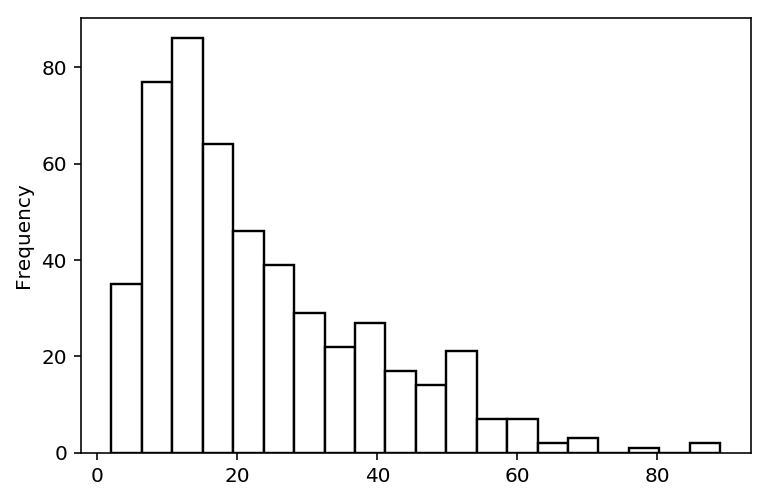

In [42]:
dist = hurricane_amount.plot.hist(bins=20, edgecolor='black', histtype='barstacked', color='white', legend=None, linewidth=1.2)
plt.show()

In [43]:
df11.to_csv('checkpoint-dataframe-new11.csv') # Save the dataframe to csv for checkpoint

In [44]:
df11 = pd.read_csv('checkpoint-dataframe-new11.csv', index_col=0, header=0)
df11.head()

,LAT,LON,VMAX,MSLP,UNIQUE-KEY
2,217,871,20,1005,ALBE-82
3,222,865,25,1004,ALBE-82
4,226,858,30,1003,ALBE-82
5,228,850,40,1001,ALBE-82
6,232,842,50,995,ALBE-82


In [46]:
# Total amount of data tuples
total_data_count = len(df11)
print(total_data_count)

11663


In [47]:
y = np.zeros(total_hurricane_count)
df11['DISTANCE'] = np.zeros(total_data_count)
df11['DIRECTION'] = np.zeros(total_data_count)
df11['LAT'] /= 10
df11['LON'] /= -10

# For all hurricanes
for x in range(0, total_hurricane_count):
    t = pd.DataFrame(df11[df11['UNIQUE-KEY'] == keys[x][1]], columns = df11.keys()).reset_index(drop = False)
    dst = 0
    prev = (0,0)
    if x == 0:
        print(t)
    
    # For all latitude and longitude points of hurricane, calculate the angle of travel and distance
    for p in zip(t['LAT'], t['LON']):
        
        if prev == (0,0):
            prev = p
            continue 
        # Stores the distance into the DataFrame #at the same place where 
        df11.set_value(t[(t['LAT'] == p[0]) & (t['LON'] == p[1])]['index'].values[0], 'DISTANCE', vc(prev,p).miles)
        
        dLon = p[1] - prev[1];  
        temp = float(p[0]) # p[0] is a str?
        #WHAT EXACTLY IS BEING CALCULATED HERE?
        #y_x = Math.sin(dLon) * Math.cos(temp)
        #x_x = Math.cos(p[1]) * Math.sin(temp) - Math.sin(p[1]) * Math.cos(temp) * Math.cos(dLon)
        y_x = Math.sin(dLon) * Math.cos(temp)
        x_x = Math.cos(prev[0]) * Math.sin(temp) - Math.sin(prev[0]) * Math.cos(temp) * Math.cos(dLon)
        #print (y_x,x_x)
        #print(p[1]-prev[1], p[0]-prev[0])
        brng = Math.degrees(Math.atan2(y_x, x_x)) 
        if (brng < 0):
            brng+= 360;
        
        # Stores the angle of travel into the DataFrame
        df11.set_value(t[(t['LAT'] == p[0]) & (t['LON'] == p[1])]['index'].values[0], 'DIRECTION', brng)
        dst += vc(prev,p).miles
        prev = p
    y[x] = dst

# Now contains the distance between all given latitude and longitude points
hurricane_distance = pd.DataFrame(y)

    index   LAT   LON  VMAX  MSLP UNIQUE-KEY  DISTANCE  DIRECTION
0       2  21.7 -87.1    20  1005    ALBE-82       0.0        0.0
1       3  22.2 -86.5    25  1004    ALBE-82       0.0        0.0
2       4  22.6 -85.8    30  1003    ALBE-82       0.0        0.0
3       5  22.8 -85.0    40  1001    ALBE-82       0.0        0.0
4       6  23.2 -84.2    50   995    ALBE-82       0.0        0.0
5       7  24.0 -83.6    75   985    ALBE-82       0.0        0.0
6       8  24.8 -83.4    65   992    ALBE-82       0.0        0.0
7       9  24.9 -84.1    55   998    ALBE-82       0.0        0.0
8      10  24.9 -84.8    45  1002    ALBE-82       0.0        0.0
9      11  25.0 -84.2    40  1005    ALBE-82       0.0        0.0
10     12  25.1 -84.1    30  1007    ALBE-82       0.0        0.0
11     13  25.2 -84.0    25  1008    ALBE-82       0.0        0.0
12     14  25.3 -83.9    25  1009    ALBE-82       0.0        0.0
13     15  25.4 -83.6    25  1010    ALBE-82       0.0        0.0
14     16 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [48]:
df11.head()

,LAT,LON,VMAX,MSLP,UNIQUE-KEY,DISTANCE,DIRECTION
2,21.7,-87.1,20,1005,ALBE-82,0.000000,0.000000
3,22.2,-86.5,25,1004,ALBE-82,51.690741,307.923684
4,22.6,-85.8,30,1003,ALBE-82,52.567404,309.096724
5,22.8,-85.0,40,1001,ALBE-82,52.832158,302.740465
6,23.2,-84.2,50,995,ALBE-82,57.902016,331.463332


In [49]:
groups = [df11 for _, df11 in df11.groupby('UNIQUE-KEY')]
random.shuffle(groups)
df11 = pd.concat(groups).reset_index(drop=True)

In [50]:
df11.head()

,LAT,LON,VMAX,MSLP,UNIQUE-KEY,DISTANCE,DIRECTION
0,12.9,-53.6,25,1010,BONN-04,0.000000,0.000000
1,13.2,-55.4,25,1010,BONN-04,122.916083,308.281225
2,13.5,-57.4,30,1010,BONN-04,136.040581,325.744406
3,13.6,-59.5,30,1010,BONN-04,141.226217,328.428134
4,13.6,-61.6,30,1010,BONN-04,141.027397,326.270931


In [51]:
df11.shape

(11663, 7)

In [52]:
hurricane_distance.describe()

,0
count,499.000000
mean,1743.897067
std,1317.061821
min,28.425255
25%,720.362601
50%,1357.415167
75%,2433.721855
max,7111.758046


In [53]:
# Print the hurricane key with the amount of data they contain
print ('Top 6 Hurricanes (in terms of distance traveled)')
for x in hurricane_distance.nlargest(6, 0).index:
    print (keys[x][1], "-", hurricane_distance.loc[x][0], "miles -", hurricane_amount.loc[x][0])

Top 6 Hurricanes (in terms of distance traveled)
IVAN-04 - 7111.758045867661 miles - 71.0
ALBE-00 - 6631.860776680004 miles - 79.0
NADI-12 - 5704.6391712663335 miles - 89.0
BERT-08 - 5257.014340221449 miles - 69.0
LUIS-95 - 5180.033778424786 miles - 60.0
HELE-00 - 5143.7116440559475 miles - 30.0


[[1.        0.8750166]
 [0.8750166 1.       ]]


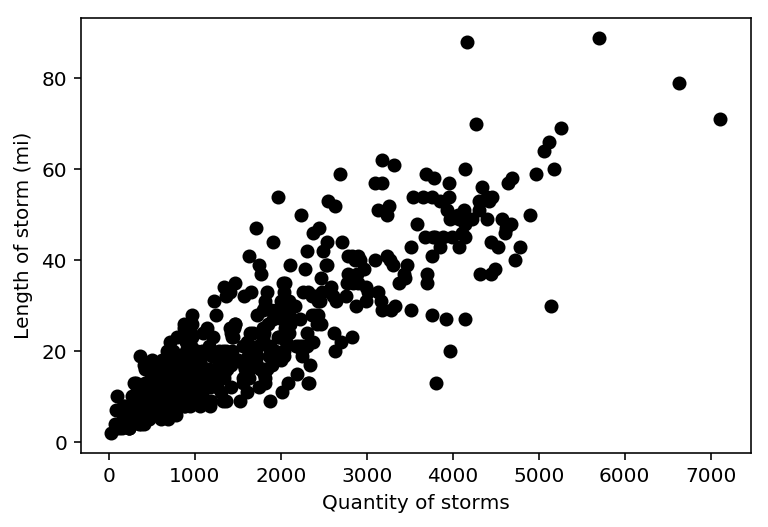

In [54]:
print( np.corrcoef(hurricane_distance[0], hurricane_amount[0]) )
# Plotted the amount of hurricane distance traveled vs the amount of data they contain.
corr = plt.scatter(hurricane_distance[0], hurricane_amount[0], color='black')
# plt.savefig('points_vs_distance', dpi=600)
plt.ylabel('Length of storm (mi)')
plt.xlabel('Quantity of storms')
plt.show()

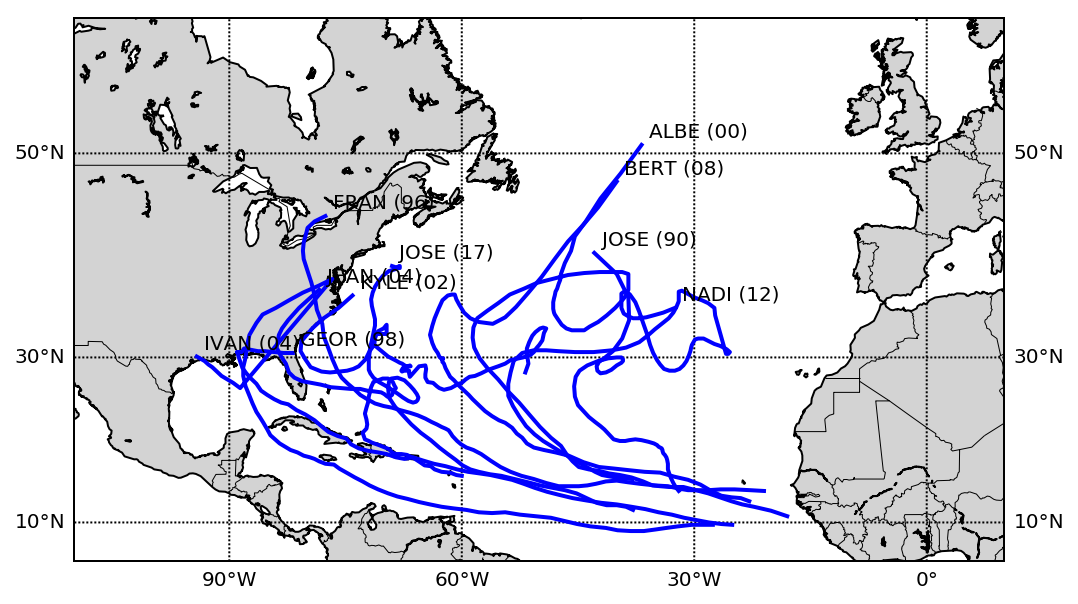

In [56]:
n = 10 # Number of hurricanes

# Graph the trajectories of the longest hurricanes (the ones that traveled the most)
plt.figure(figsize=(10,5))
m = Basemap(llcrnrlon=-110.,llcrnrlat=5.,urcrnrlon=10.,urcrnrlat=60.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',
            projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

for x in hurricane_amount.nlargest(n,0).index:
    largest_hurr = df11[df11['UNIQUE-KEY'] == keys[x][1]]
    lat = largest_hurr['LAT'].values
    long = largest_hurr['LON'].values
    xpt, ypt = m(long, lat)
    plt.text(xpt[len(lat) - 1]+100000,ypt[len(long) - 1]+100000, '%s (%s)' % (keys[x][1].split('-')[0],keys[x][1].split('-')[1]))
    m.plot(xpt, ypt, linewidth=2, color='blue')
    
# plt.title('Top 5 Atlantic Hurricanes (Distance Traveled)')
# plt.savefig('largest_dist_hurricanes')
plt.show()

In [ ]:
# Graph the trajectories of the shortest hurricanes (the ones that traveled the least)
plt.figure(figsize=(10,5))
m = Basemap(llcrnrlon=-110.,llcrnrlat=5.,urcrnrlon=10.,urcrnrlat=60.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',
            projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

for x in hurricane_amount.nsmallest(n,0).index:
    largest_hurr = df11[df11['UNIQUE-KEY'] == keys[x][1]]
    lat = largest_hurr['LAT'].values
    long = largest_hurr['LON'].values
    xpt, ypt = m(long, lat)
    plt.text(xpt[0]+100000,ypt[0]+100000, '%s (%s)' % (keys[x][1].split('-')[0],keys[x][1].split('-')[1]))
    m.plot(xpt, ypt, linewidth=2, color='blue')
    
# plt.title('Smallest 5 Atlantic Hurricanes (Distance Traveled)')
# plt.savefig('smallest_dist_hurricanes')
plt.show()

In [ ]:
# Graph the trajectories of 3 random hurricanes 
plt.figure(figsize=(10,5))
m = Basemap(llcrnrlon=-110.,llcrnrlat=5.,urcrnrlon=10.,urcrnrlat=60.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',
            projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

for x in np.random.choice(total_hurricane_count, n):
    largest_hurr = df11[df11['UNIQUE-KEY'] == keys[x][1]]
    lat = largest_hurr['LAT'].values
    long = largest_hurr['LON'].values
    xpt, ypt = m(long, lat)
    plt.text(xpt[0]+100000,ypt[0]+100000, '%s (%s)' % (keys[x][1].split('-')[0],keys[x][1].split('-')[1]))
    m.plot(xpt, ypt, linewidth=2, color='blue')
    
# plt.title('Random 5 Atlantic Hurricanes')
# plt.savefig('random_dist_hurricanes')
plt.show()

In [ ]:
# Graph all points 
plt.figure(figsize=(10,5))
m = Basemap(llcrnrlon=-110.,llcrnrlat=5.,urcrnrlon=10.,urcrnrlat=60.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',
            projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

lat = df11['LAT'].values
long = df11['LON'].values
xpt, ypt = m(long, lat)
m.scatter(xpt, ypt, .3, color='blue')

# plt.savefig('scatter_hurricanes')
plt.show()

In [60]:
df11.to_csv('checkpoint-dataframe-new21.csv') # Save the dataframe to csv for checkpoint

In [2]:
df11 = pd.read_csv('checkpoint-dataframe-new21.csv', index_col=0) 

In [3]:
scaler = MinMaxScaler(feature_range=(0,1))

#df11['LAT_NN'] = df11['LAT']
#df11['LON_NN'] = df11['LON']
#df11['VMAX_NN'] = df11['VMAX']
df11['LAT'] = scaler.fit_transform(df11['LAT'].values.reshape(-1,1))
df11['LON'] = scaler.fit_transform(df11['LON'].values.reshape(-1,1))
df11['VMAX'] = scaler.fit_transform(df11['VMAX'].values.reshape(-1,1))
df11['MSLP'] = scaler.fit_transform(df11['MSLP'].values.reshape(-1,1))
df11['DISTANCE'] = scaler.fit_transform(df11['DISTANCE'].values.reshape(-1,1))
df11['DIRECTION'] = scaler.fit_transform(df11['DIRECTION'].values.reshape(-1,1))

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [4]:
df11.head()

,LAT,LON,VMAX,MSLP,UNIQUE-KEY,DISTANCE,DIRECTION
0,0.127517,0.539206,0.100000,0.914286,BONN-04,0.000000,0.000000
1,0.134228,0.521781,0.100000,0.914286,BONN-04,0.045545,0.856388
2,0.140940,0.502420,0.133333,0.914286,BONN-04,0.050408,0.904900
3,0.143177,0.482091,0.133333,0.914286,BONN-04,0.052330,0.912355
4,0.143177,0.461762,0.133333,0.914286,BONN-04,0.052256,0.906363


In [5]:
cols = ['LAT', 'LON', 'VMAX', 'MSLP', 'DISTANCE', 'DIRECTION', 'UNIQUE-KEY']
df11 = df11[cols]

In [6]:
df11[0:15]

,LAT,LON,VMAX,MSLP,DISTANCE,DIRECTION,UNIQUE-KEY
0,0.127517,0.539206,0.100000,0.914286,0.000000,0.000000,BONN-04
1,0.134228,0.521781,0.100000,0.914286,0.045545,0.856388,BONN-04
2,0.140940,0.502420,0.133333,0.914286,0.050408,0.904900,BONN-04
3,0.143177,0.482091,0.133333,0.914286,0.052330,0.912355,BONN-04
4,0.143177,0.461762,0.133333,0.914286,0.052256,0.906363,BONN-04
5,0.293065,0.249758,0.100000,0.907143,0.562442,0.997213,BONN-04
6,0.306488,0.242014,0.100000,0.900000,0.024566,0.105201,BONN-04
7,0.319911,0.230397,0.100000,0.900000,0.032502,0.237295,BONN-04
8,0.331096,0.219748,0.133333,0.900000,0.029121,0.211202,BONN-04
9,0.342282,0.210068,0.166667,0.900000,0.026932,0.157469,BONN-04


In [7]:
df11_shifted = df11.copy()
df11_shifted['LAT2'] = df11_shifted['LAT'].shift(-4)
df11_shifted.head(10)

,LAT,LON,VMAX,MSLP,DISTANCE,DIRECTION,UNIQUE-KEY,LAT2
0,0.127517,0.539206,0.100000,0.914286,0.000000,0.000000,BONN-04,0.143177
1,0.134228,0.521781,0.100000,0.914286,0.045545,0.856388,BONN-04,0.293065
2,0.140940,0.502420,0.133333,0.914286,0.050408,0.904900,BONN-04,0.306488
3,0.143177,0.482091,0.133333,0.914286,0.052330,0.912355,BONN-04,0.319911
4,0.143177,0.461762,0.133333,0.914286,0.052256,0.906363,BONN-04,0.331096
5,0.293065,0.249758,0.100000,0.907143,0.562442,0.997213,BONN-04,0.342282
6,0.306488,0.242014,0.100000,0.900000,0.024566,0.105201,BONN-04,0.351230
7,0.319911,0.230397,0.100000,0.900000,0.032502,0.237295,BONN-04,0.355705
8,0.331096,0.219748,0.133333,0.900000,0.029121,0.211202,BONN-04,0.362416
9,0.342282,0.210068,0.166667,0.900000,0.026932,0.157469,BONN-04,0.375839


In [8]:
df11.head()

,LAT,LON,VMAX,MSLP,DISTANCE,DIRECTION,UNIQUE-KEY
0,0.127517,0.539206,0.100000,0.914286,0.000000,0.000000,BONN-04
1,0.134228,0.521781,0.100000,0.914286,0.045545,0.856388,BONN-04
2,0.140940,0.502420,0.133333,0.914286,0.050408,0.904900,BONN-04
3,0.143177,0.482091,0.133333,0.914286,0.052330,0.912355,BONN-04
4,0.143177,0.461762,0.133333,0.914286,0.052256,0.906363,BONN-04


In [9]:
df11['UNIQUE-KEY'].unique()

array(['BONN-04', 'NICO-04', 'DEAN-83', 'TONY-12', 'HARV-17', 'IRIS-89',
       'TD12-99', 'NATE-17', 'SEAN-11', 'MICH-12', 'FRAN-92', 'ANDR-07',
       'CHAN-01', 'FABI-91', 'EARL-98', 'TD02-99', 'FELI-01', 'UNNA-11',
       'BERT-96', 'CRIS-08', 'RITA-05', 'ELEN-85', 'CESA-90', 'KARE-95',
       'ERIN-01', 'TD02-14', 'JOSE-17', 'ISAB-85', 'BERT-84', 'GLOR-85',
       'KATE-15', 'JOSE-02', 'MITC-98', 'IVAN-04', 'MATT-04', 'DOLL-02',
       'TD09-94', 'GUST-02', 'JERR-13', 'CHAR-04', 'ISAB-03', 'CHAN-13',
       'TD04-91', 'DORI-13', 'ALBE-82', 'JOSE-84', 'ALBE-94', 'TD10-93',
       'ALEX-98', 'VINC-05', 'JOYC-00', 'CIND-99', 'ERIN-07', 'TD01-09',
       'DANI-10', 'FLOR-06', 'BERY-82', 'ERNE-12', 'CHRI-82', 'PHIL-11',
       'ARTH-96', 'RAFA-12', 'KATI-17', 'FELI-07', 'KATR-99', 'DANI-98',
       'ANDR-86', 'FERN-13', 'ERNE-00', 'IDA-15', 'BRET-17', 'IAN-16',
       'BOB-85', 'HARV-11', 'LISA-04', 'TD02-01', 'KARL-10', 'GUST-90',
       'ALEX-04', 'EMIL-93', 'DANN-97', 'DEAN-95', 'TD

In [101]:
test = df11.groupby('UNIQUE-KEY')
stone = test.get_group('HELE-06')
len(stone)

49

In [127]:
a = np.array([[5, 3, 2],[2,7,9]])
print(a)

# b = np.zeros(10)
# #b[:len(a)] = a
# print(b)
# test_11 = np.pad(a, (len(b)-len(a),0), 'constant')
# print(test_11)

for i in range(a.shape[0]):
    print('i', i)
    test_12 = np.pad(a[i], (len(b)-len(a[i]),0), 'constant')

print(test_12)

print(a.shape[0])

[[5 3 2]
 [2 7 9]]
i 0
i 1
[0 0 0 0 0 0 0 2 7 9]
2


In [171]:
hurricane_groups = df11.groupby('UNIQUE-KEY')
hdfttt = hurricane_groups.get_group('BONN-04')
print(hdfttt)

         LAT       LON      VMAX      MSLP  DISTANCE  DIRECTION UNIQUE-KEY
0   0.127517  0.539206  0.100000  0.914286  0.000000   0.000000    BONN-04
1   0.134228  0.521781  0.100000  0.914286  0.045545   0.856388    BONN-04
2   0.140940  0.502420  0.133333  0.914286  0.050408   0.904900    BONN-04
3   0.143177  0.482091  0.133333  0.914286  0.052330   0.912355    BONN-04
4   0.143177  0.461762  0.133333  0.914286  0.052256   0.906363    BONN-04
5   0.293065  0.249758  0.100000  0.907143  0.562442   0.997213    BONN-04
6   0.306488  0.242014  0.100000  0.900000  0.024566   0.105201    BONN-04
7   0.319911  0.230397  0.100000  0.900000  0.032502   0.237295    BONN-04
8   0.331096  0.219748  0.133333  0.900000  0.029121   0.211202    BONN-04
9   0.342282  0.210068  0.166667  0.900000  0.026932   0.157469    BONN-04
10  0.351230  0.203291  0.200000  0.892857  0.019448   0.113152    BONN-04
11  0.355705  0.196515  0.233333  0.885714  0.017273   0.126626    BONN-04
12  0.362416  0.188771  0

In [134]:
for hurricane in df11.groupby('UNIQUE-KEY'):
    print(test)

In [48]:
#load in entire pandas dataframe of 499 hurricanes
#split into 80% training and 20% testing
#train should be 
#maximum hurricane length is 89 timesteps 
#require minimum length 4 before making predictions? 
#left side padding 
def load_data(dframe, num_features, y_cols, min_to_start_predictions, max_hurricane, prediction_length, test_size):
    pre_pad_x = []
    y = []
    x = []
    hurricane_groups = dframe.groupby('UNIQUE-KEY')
    hurricane_list = dframe['UNIQUE-KEY'].unique()
    hurr_name = []
         
    for hurricane in hurricane_list:
        hdf = hurricane_groups.get_group(hurricane)
        
        if len(hdf) < (min_to_start_predictions + prediction_length):
            continue
        else:
            for i in range(min_to_start_predictions - 1,len(hdf) - prediction_length):
                pre_pad_x.append(hdf.iloc[0:i+1, :num_features])
                #print(pre_pad_x)
                y.append(hdf.iloc[i+prediction_length, y_cols])
                #print(y)
                hurr_name.append(hurricane)
    print(type(pre_pad_x))
    print(pre_pad_x[0:5])
    print(y[0:5])
    y = np.asarray(y)
    print(y[0:5])
    #pre_pad_x = np.asarray(pre_pad_x)

    #pad from left up to max_hurricane
    lengths = [len(pre_pad_x[i]) for i in range(len(pre_pad_x))]
    zs_added = [max_hurricane-len(pre_pad_x[i]) for i in range(len(pre_pad_x))]
    for i in range(len(pre_pad_x)):
        #pdb.set_trace()
        x.append(np.pad(pre_pad_x[i], ((max_hurricane-len(pre_pad_x[i]),0),(0,0)), 'constant'))
    x = np.asarray(x)
            
    #split x and y into train and test using test_size
    cutoff = len(x)*(1-test_size)
    x_train = x[:int(cutoff), :]
    x_test = x[int(cutoff):, :]
    y_train = y[:int(cutoff), :]
    y_test = y[int(cutoff):, :]
    
    #how to keep track of which data is associated with which hurricane
            
    return [x_train, y_train, x_test, y_test]       

In [106]:
#load in entire pandas dataframe of 499 hurricanes
#split into 80% training and 20% testing
#train should be 
#maximum hurricane length is 89 timesteps 
#require minimum length 4 before making predictions? 
#left side padding 
def load_data2(dframe, num_features, y_cols, min_to_start_predictions, max_hurricane, prediction_length, test_size):
    pre_pad_x = []
    y = []
    x = []
    hurricane_groups = dframe.groupby('UNIQUE-KEY')
    hurricane_list = dframe['UNIQUE-KEY'].unique()
    hurr_name = []
    segment_type = []
    hurr_lat = []
    hurr_lon = []
    hurr_name_pred = []
         
    for hurricane in hurricane_list:
        hdf = hurricane_groups.get_group(hurricane)
        
        for i in range(len(hdf)):
            hurr_name.append(hurricane)
            hurr_lat.append(hdf.iloc[i, 0])
            hurr_lon.append(hdf.iloc[i, 1])
            if len(hdf) < (min_to_start_predictions + prediction_length):
                segment_type.append(2) #before -1, during 0, after 1, nopreds 2
                continue
                
            if i < min_to_start_predictions - 1:
                segment_type.append(-1)
                
            elif i >= min_to_start_predictions - 1 and i < len(hdf) - prediction_length:
                segment_type.append(0)
                hurr_name_pred.append(hurricane)
                pre_pad_x.append(hdf.iloc[0:i+1, :num_features])
                y.append(hdf.iloc[i+prediction_length, y_cols])
                
            elif i >= len(hdf) - prediction_length:
                segment_type.append(1)
                
#         print(segment_type)
#         print(hurr_name)
#         print(pre_pad_x)
#         print(y)

                
                
#             for i in range(min_to_start_predictions - 1,len(hdf) - prediction_length):
#                 pre_pad_x.append(hdf.iloc[0:i+1, :num_features])
#                 #print(pre_pad_x)
#                 y.append(hdf.iloc[i+prediction_length, y_cols])
#                 #print(y)
#                 hurr_name.append(hurricane)
#     print(type(pre_pad_x))
#     print(pre_pad_x[0:5])
#     print(y[0:5])
    y = np.asarray(y)
#     print(y[0:5])
    #pre_pad_x = np.asarray(pre_pad_x)

    #pad from left up to max_hurricane
    lengths = [len(pre_pad_x[i]) for i in range(len(pre_pad_x))]
    zs_added = [max_hurricane-len(pre_pad_x[i]) for i in range(len(pre_pad_x))]
    for i in range(len(pre_pad_x)):
        #pdb.set_trace()
        x.append(np.pad(pre_pad_x[i], ((max_hurricane-len(pre_pad_x[i]),0),(0,0)), 'constant'))
    x = np.asarray(x)
            
    #split x and y into train and test using test_size
    cutoff = len(x)*(1-test_size)
    x_train = x[:int(cutoff), :]
    x_test = x[int(cutoff):, :]
    y_train = y[:int(cutoff), :]
    y_test = y[int(cutoff):, :]
    
    #how to keep track of which data is associated with which hurricane
            
    return [x_train, y_train, x_test, y_test, hurr_lat, hurr_lon, hurr_name, segment_type, hurr_name_pred]       

In [166]:
test11 = pd.DataFrame({'LAT_P': [1,2,3], 'LON_P': [4,5,6]})
prediction_length = 4
y_cols = [7, 8]
test11 = test11.append(dfht.iloc[i+prediction_length, y_cols])
print(test11)

      LAT_P     LON_P
0  1.000000  4.000000
1  2.000000  5.000000
2  3.000000  6.000000
5  0.293065  0.249758


In [160]:
df11.head()

,LAT,LON,VMAX,MSLP,DISTANCE,DIRECTION,UNIQUE-KEY
0,0.127517,0.539206,0.100000,0.914286,0.000000,0.000000,BONN-04
1,0.134228,0.521781,0.100000,0.914286,0.045545,0.856388,BONN-04
2,0.140940,0.502420,0.133333,0.914286,0.050408,0.904900,BONN-04
3,0.143177,0.482091,0.133333,0.914286,0.052330,0.912355,BONN-04
4,0.143177,0.461762,0.133333,0.914286,0.052256,0.906363,BONN-04


In [12]:
dfht = df11.copy()
dfht['LAT_P'] = dfht['LAT']
dfht['LON_P'] = dfht['LON']
dfht.head()

,LAT,LON,VMAX,MSLP,DISTANCE,DIRECTION,UNIQUE-KEY,LAT_P,LON_P
0,0.127517,0.539206,0.100000,0.914286,0.000000,0.000000,BONN-04,0.127517,0.539206
1,0.134228,0.521781,0.100000,0.914286,0.045545,0.856388,BONN-04,0.134228,0.521781
2,0.140940,0.502420,0.133333,0.914286,0.050408,0.904900,BONN-04,0.140940,0.502420
3,0.143177,0.482091,0.133333,0.914286,0.052330,0.912355,BONN-04,0.143177,0.482091
4,0.143177,0.461762,0.133333,0.914286,0.052256,0.906363,BONN-04,0.143177,0.461762


In [107]:
[x_train, y_train, x_test, y_test, hurr_lat, hurr_lon, hurr_name, segment_type, hurr_name_pred] = load_data2(dfht, 6, [7,8], 4, 89, 4, 0.2)

In [ ]:
# for i in range(len(pre_pad_x)):
#     pdb.set_trace()
#     x.append(np.pad(pre_pad_x[i], (max_hurricane-len(pre_pad_x[i]),0), 'constant'))

In [39]:
def build_model(layers, dropout): #layers are 5, 12, 1, LSTM1 5-12, LSTM2 5-12, LSTM3 5-12, LSTM4 
    rd = 0.5
    #dd = 0.1
    inputs = keras.Input(shape=(layers[1],layers[0]))
    x = keras.layers.LSTM(30, recurrent_dropout=rd, return_sequences=True)(inputs, training=True)
    x = keras.layers.Dropout(dropout)(x, training=True)
    #x = keras.layers.LSTM(layers[1], recurrent_dropout=dropout, return_sequences=True)(x, training=True)
    #x = keras.layers.Dropout(dropout)(x, training=True)
    x = keras.layers.LSTM(30, recurrent_dropout=rd)(x, training=True)
    #x = keras.layers.LSTM(layers[1])(x, training=True)
    x = keras.layers.Dropout(dropout)(x, training=True)
    outputs = keras.layers.Dense(layers[2])(x)
    model = keras.Model(inputs, outputs)
#     model = Sequential()

#     for x in range(0,3):
#         model.add(LSTM(input_dim=layers[0], output_dim=layers[1], return_sequences=True, dropout=0.25, recurrent_dropout=0.25))

#     model.add(LSTM(layers[2], return_sequences=False, dropout=0.25, recurrent_dropout=0.25)) 

#     model.add(Dense(output_dim=layers[2]))
#     model.add(Activation("tanh"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy', 'mse'])
    print("Compilation Time : ", time.time() - start)
    return model

In [ ]:
#LAT	LON	VMAX	MSLP	UNIQUE-KEY	DISTANCE	DIRECTION	LAT_NN	LON_NN	VMAX_NN
df_in_latlon = df11.drop(['VMAXP'], axis = 1)
df_in_vmax = df11.drop(['TIME', 'UNIQUE-KEY', 'LATP', 'LONP'], axis = 1)

In [64]:
nplatlon = np.array(df_in_latlon)
npvmax = np.array(df_in_vmax)

NameError: name 'df_in_latlon' is not defined

In [ ]:
seq_len = 8 #4, 8, 12 Another hyperparameter- length of hurricane?
feature_count = 6
#X_train, y_train, X_test, y_test = load_data(temp_flat[::-1], seq_len, feature_count, [0,1])
X_train, y_train, X_test, y_test = load_data_y(nplatlon_t, seq_len, feature_count, [6, 7])
# X_trainV, y_trainV, X_testV, y_testV = load_data_y(npvmaxN, seq_len, feature_count, 6)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)
print("X_trainV", X_trainV.shape)
print("y_trainV", y_trainV.shape)
print("X_testV", X_testV.shape)
print("y_testV", y_testV.shape)

In [50]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(6602, 89, 6)
(6602, 2)
(1651, 89, 6)
(1651, 2)


In [ ]:
y_

In [42]:
feature_count = 6
seq_len = 89
model = build_model([feature_count, seq_len, 2],0.1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Compilation Time :  0.022420883178710938


In [77]:
history = model.fit(x_train, y_train, batch_size=64, epochs=150, validation_split=0.20, verbose=1)

Train on 5281 samples, validate on 1321 samples
Epoch 1/150
5281/5281 [==============================] - 13s 2ms/step - loss: 0.0017 - acc: 0.9449 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_acc: 0.9394 - val_mean_squared_error: 0.0017
Epoch 2/150
5281/5281 [==============================] - 13s 3ms/step - loss: 0.0017 - acc: 0.9483 - mean_squared_error: 0.0017 - val_loss: 0.0016 - val_acc: 0.9357 - val_mean_squared_error: 0.0016
Epoch 3/150
5281/5281 [==============================] - 14s 3ms/step - loss: 0.0017 - acc: 0.9430 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_acc: 0.9417 - val_mean_squared_error: 0.0017
Epoch 4/150
5281/5281 [==============================] - 14s 3ms/step - loss: 0.0017 - acc: 0.9436 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_acc: 0.9357 - val_mean_squared_error: 0.0017
Epoch 5/150
5281/5281 [==============================] - 15s 3ms/step - loss: 0.0017 - acc: 0.9470 - mean_squared_error: 0.0017 - val_loss: 0.0016 - val_acc: 0.

Epoch 42/150
5281/5281 [==============================] - 14s 3ms/step - loss: 0.0017 - acc: 0.9491 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_acc: 0.9455 - val_mean_squared_error: 0.0017
Epoch 43/150
5281/5281 [==============================] - 14s 3ms/step - loss: 0.0016 - acc: 0.9440 - mean_squared_error: 0.0016 - val_loss: 0.0017 - val_acc: 0.9357 - val_mean_squared_error: 0.0017
Epoch 44/150
5281/5281 [==============================] - 14s 3ms/step - loss: 0.0017 - acc: 0.9483 - mean_squared_error: 0.0017 - val_loss: 0.0018 - val_acc: 0.9349 - val_mean_squared_error: 0.0018
Epoch 45/150
5281/5281 [==============================] - 14s 3ms/step - loss: 0.0016 - acc: 0.9470 - mean_squared_error: 0.0016 - val_loss: 0.0017 - val_acc: 0.9432 - val_mean_squared_error: 0.0017
Epoch 46/150
5281/5281 [==============================] - 14s 3ms/step - loss: 0.0017 - acc: 0.9445 - mean_squared_error: 0.0017 - val_loss: 0.0017 - val_acc: 0.9364 - val_mean_squared_error: 0.0017
Epoch

5281/5281 [==============================] - 13s 3ms/step - loss: 0.0016 - acc: 0.9462 - mean_squared_error: 0.0016 - val_loss: 0.0018 - val_acc: 0.9296 - val_mean_squared_error: 0.0018
Epoch 84/150
5281/5281 [==============================] - 13s 2ms/step - loss: 0.0016 - acc: 0.9475 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_acc: 0.9372 - val_mean_squared_error: 0.0016
Epoch 85/150
5281/5281 [==============================] - 13s 2ms/step - loss: 0.0016 - acc: 0.9455 - mean_squared_error: 0.0016 - val_loss: 0.0017 - val_acc: 0.9455 - val_mean_squared_error: 0.0017
Epoch 86/150
5281/5281 [==============================] - 13s 2ms/step - loss: 0.0016 - acc: 0.9438 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_acc: 0.9394 - val_mean_squared_error: 0.0016
Epoch 87/150
5281/5281 [==============================] - 13s 2ms/step - loss: 0.0016 - acc: 0.9434 - mean_squared_error: 0.0016 - val_loss: 0.0017 - val_acc: 0.9447 - val_mean_squared_error: 0.0017
Epoch 88/150
5281/

5281/5281 [==============================] - 13s 3ms/step - loss: 0.0016 - acc: 0.9460 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_acc: 0.9463 - val_mean_squared_error: 0.0016
Epoch 125/150
5281/5281 [==============================] - 13s 3ms/step - loss: 0.0016 - acc: 0.9440 - mean_squared_error: 0.0016 - val_loss: 0.0016 - val_acc: 0.9326 - val_mean_squared_error: 0.0016
Epoch 126/150
5281/5281 [==============================] - 14s 3ms/step - loss: 0.0016 - acc: 0.9457 - mean_squared_error: 0.0016 - val_loss: 0.0017 - val_acc: 0.9364 - val_mean_squared_error: 0.0017
Epoch 127/150
5281/5281 [==============================] - 13s 3ms/step - loss: 0.0016 - acc: 0.9500 - mean_squared_error: 0.0016 - val_loss: 0.0015 - val_acc: 0.9432 - val_mean_squared_error: 0.0015
Epoch 128/150
5281/5281 [==============================] - 13s 3ms/step - loss: 0.0016 - acc: 0.9430 - mean_squared_error: 0.0016 - val_loss: 0.0017 - val_acc: 0.9288 - val_mean_squared_error: 0.0017
Epoch 129/150


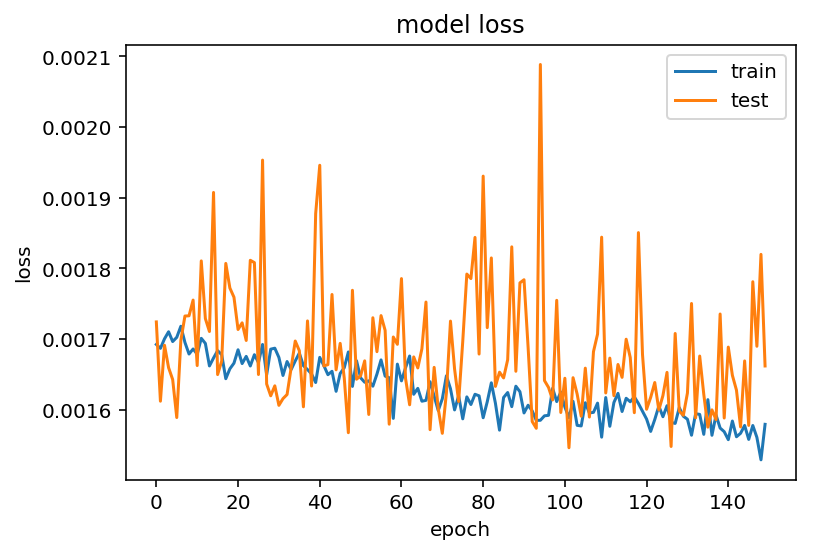

In [78]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
#plt.ylim([0,0.02])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [79]:
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.4f MSE (%.4f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.4f MSE (%.4f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.0016 MSE (0.0405 RMSE)
Test Score: 0.0014 MSE (0.0379 RMSE)


In [80]:
preds = []
for i in range(100):
    model_output = model.predict(x_test)
    preds.append(model_output)

In [81]:
p100 = np.array(preds)
p100mean = np.mean(p100, axis=0)
p100std = np.std(p100, axis=0)

In [85]:
x_test.shape

(1651, 89, 6)

In [86]:
p100.shape

(100, 1651, 2)

In [87]:
y_test.shape

(1651, 2)

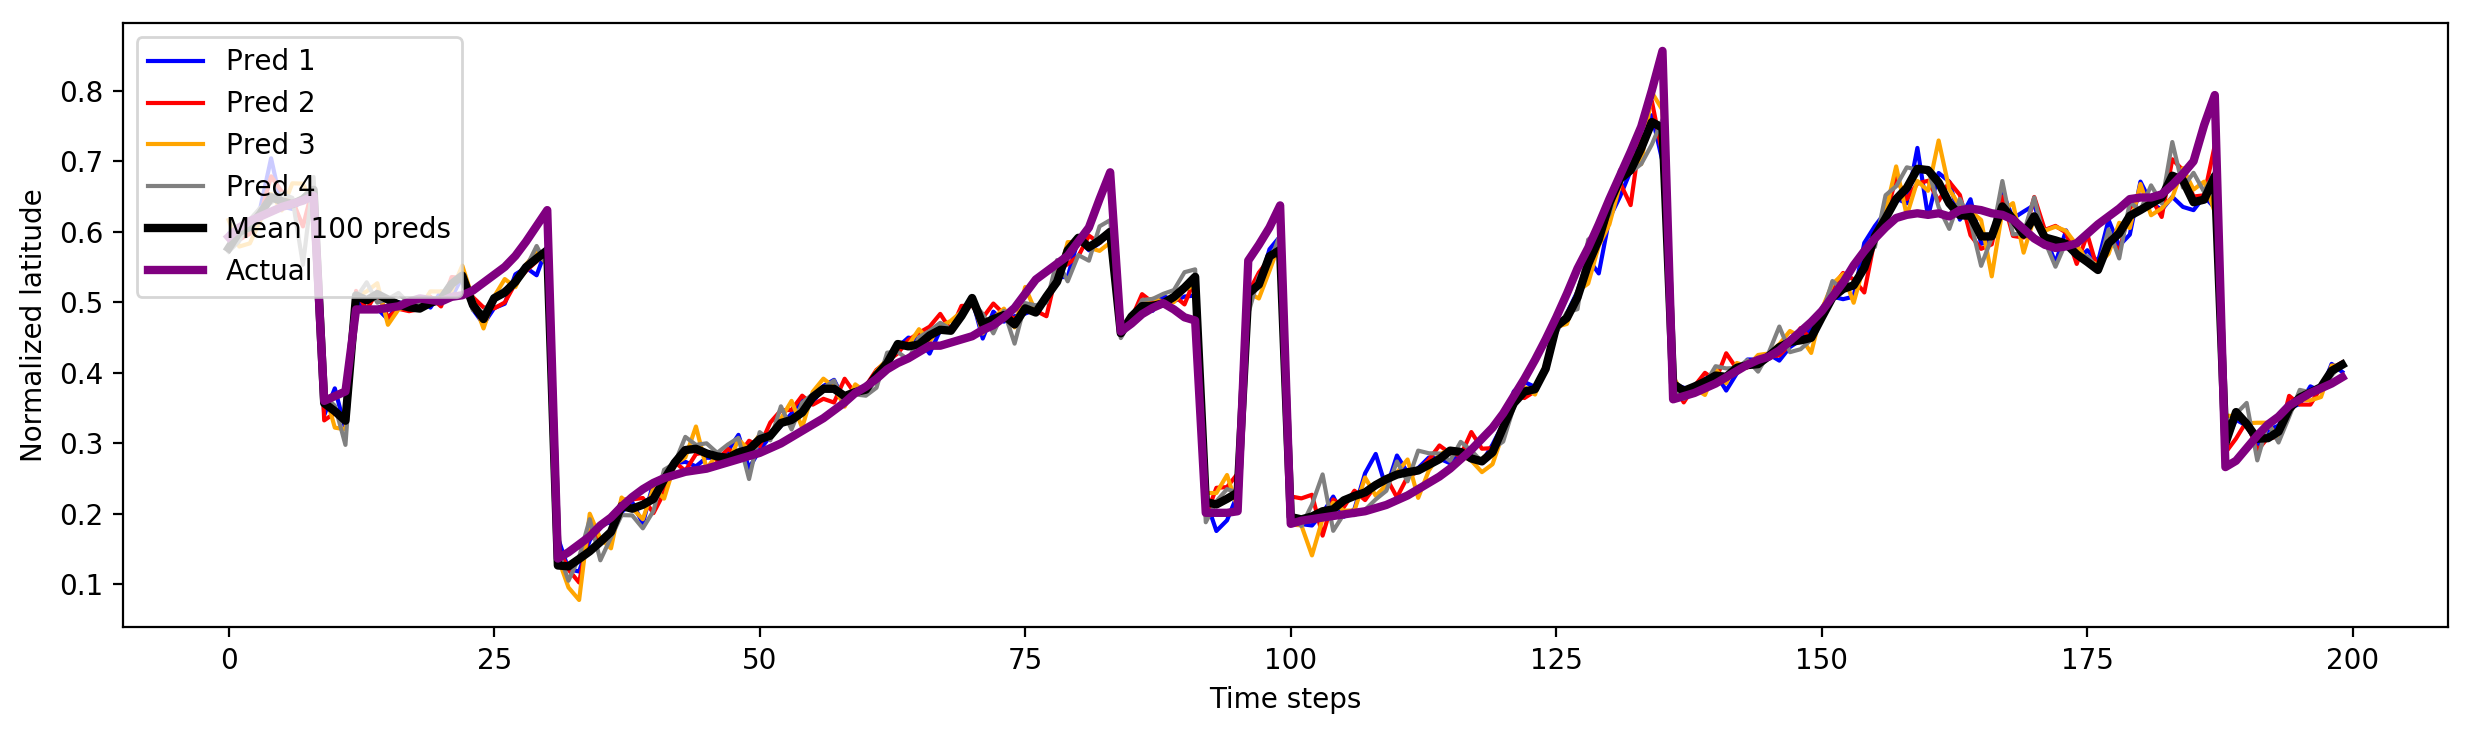

In [88]:


plt.figure(figsize=(15, 4), dpi=100)
plt.plot(p100[3][:,0][0:200], color='blue', label='Pred 1')
plt.plot(p100[13][:,0][0:200], color='red', label='Pred 2')
plt.plot(p100[23][:,0][0:200], color='orange', label = 'Pred 3')
plt.plot(p100[33][:,0][0:200], color='gray', label = 'Pred 4')
plt.plot(p100mean[:,0][0:200], color='black', linewidth=3, label = 'Mean 100 preds')
plt.plot(y_test[:,0][0:200], color='purple', linewidth=3, label = 'Actual')
plt.legend(loc='upper left')
plt.ylabel('Normalized latitude')
plt.xlabel('Time steps')
plt.show()

In [ ]:
for i in range

[x_train, y_train, x_test, y_test, hurr_lat, hurr_lon, hurr_name, segment_type, hurr_name_pred] 

for h, lat, :
    for i in range(len(hurricane)):
        
    hdf = hurricane_groups.get_group(hurricane)
    
    
#go through every hurricane and if no predictions just show hurricane, otherwise show first part with no 

In [115]:
len(hurr_name_pred)
len(segment_type)
len(y_test)

1651

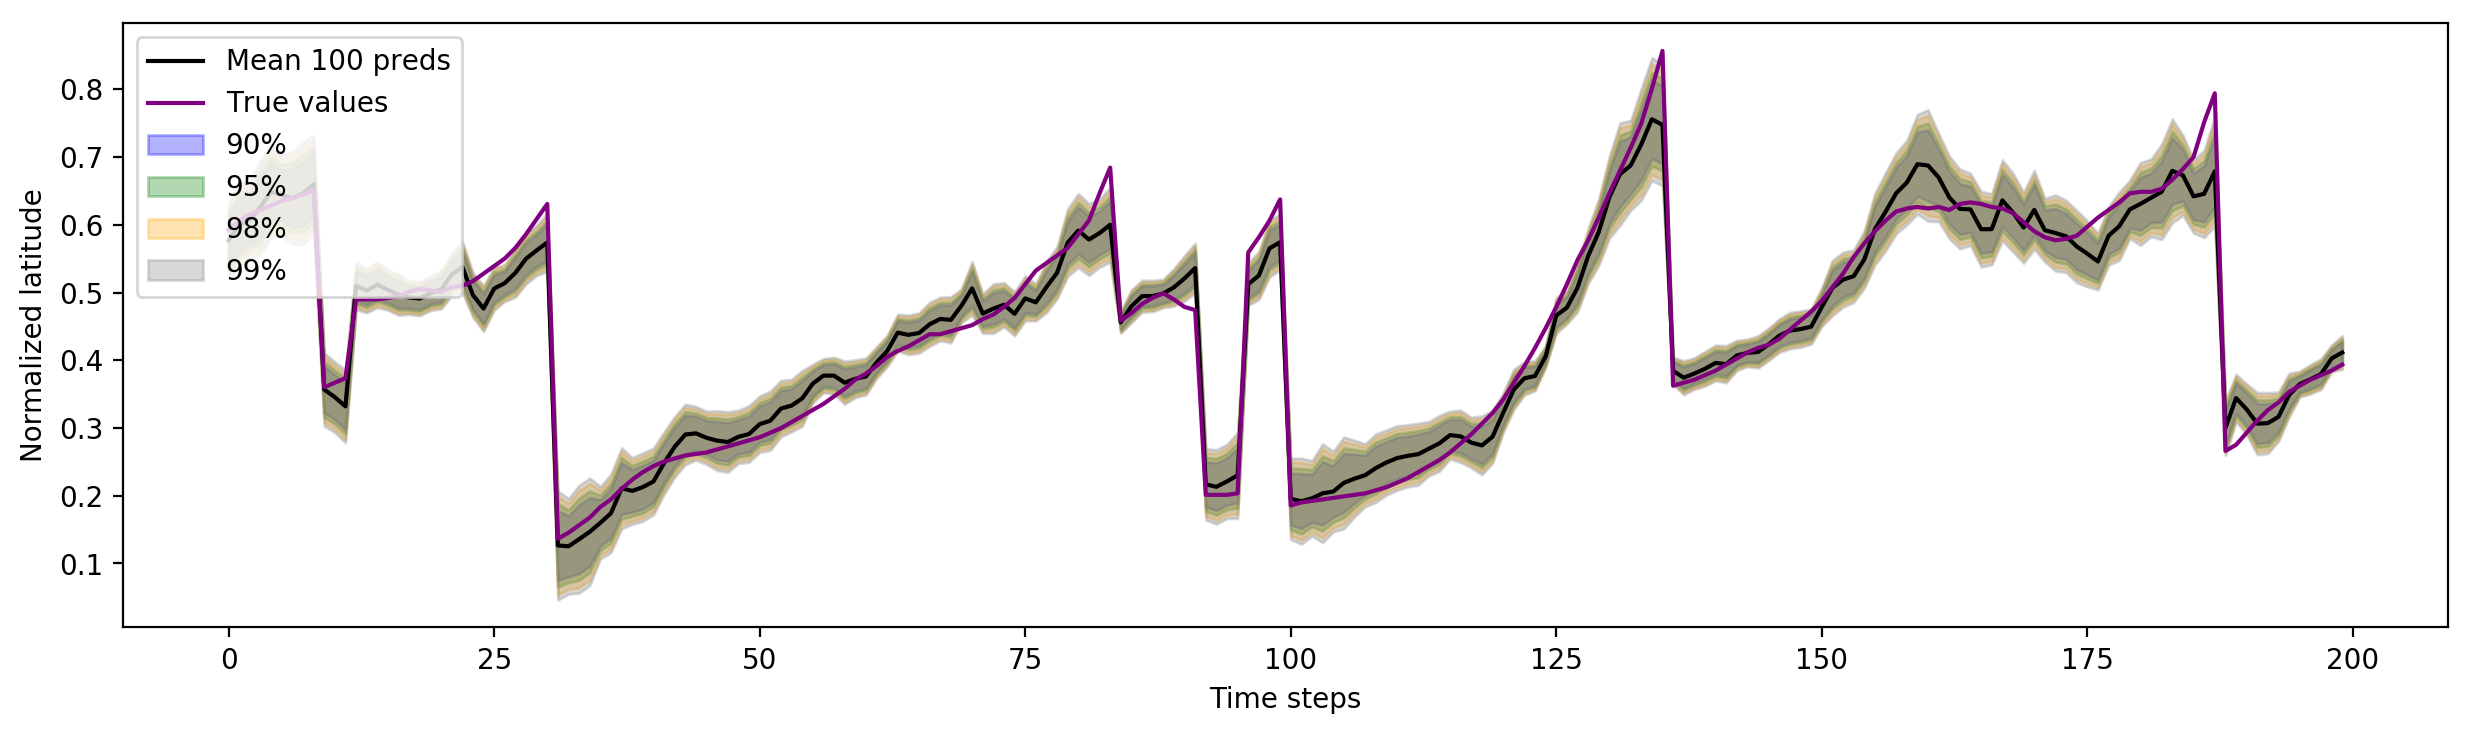

In [105]:
z_95 = 1.96
z_90 = 1.645
z_98 = 2.326
z_99 = 2.576

min1 = 0
max1 = 200
diff1 = max1 - min1

z_scores = [z_90, z_95, z_98, z_99]
colors = ['blue', 'yellow', 'orange', 'green']
pct = [90, 95, 98, 99]

plt.figure(figsize=(15, 4), dpi=100)
plt.plot(p100mean[:,0][min1:max1], color='black', label = 'Mean 100 preds')
plt.plot(y_test[:,0][min1:max1], color='purple', label = 'True values')
plt.fill_between(range(diff1), p100mean[:,0][min1:max1]-z_90*p100std[:,0][min1:max1], p100mean[:,0][min1:max1]+z_90*p100std[:,0][min1:max1], label='90%', color='blue', alpha=.3)
plt.fill_between(range(diff1), p100mean[:,0][min1:max1]-z_95*p100std[:,0][min1:max1], p100mean[:,0][min1:max1]+z_95*p100std[:,0][min1:max1], label='95%', color='green', alpha=.3)
plt.fill_between(range(diff1), p100mean[:,0][min1:max1]-z_98*p100std[:,0][min1:max1], p100mean[:,0][min1:max1]+z_98*p100std[:,0][min1:max1], label='98%', color='orange', alpha=.3)
plt.fill_between(range(diff1), p100mean[:,0][min1:max1]-z_99*p100std[:,0][min1:max1], p100mean[:,0][min1:max1]+z_99*p100std[:,0][min1:max1], label='99%', color='gray', alpha=.3)
plt.legend(loc='upper left')
plt.ylabel('Normalized latitude')
plt.xlabel('Time steps')
plt.show()

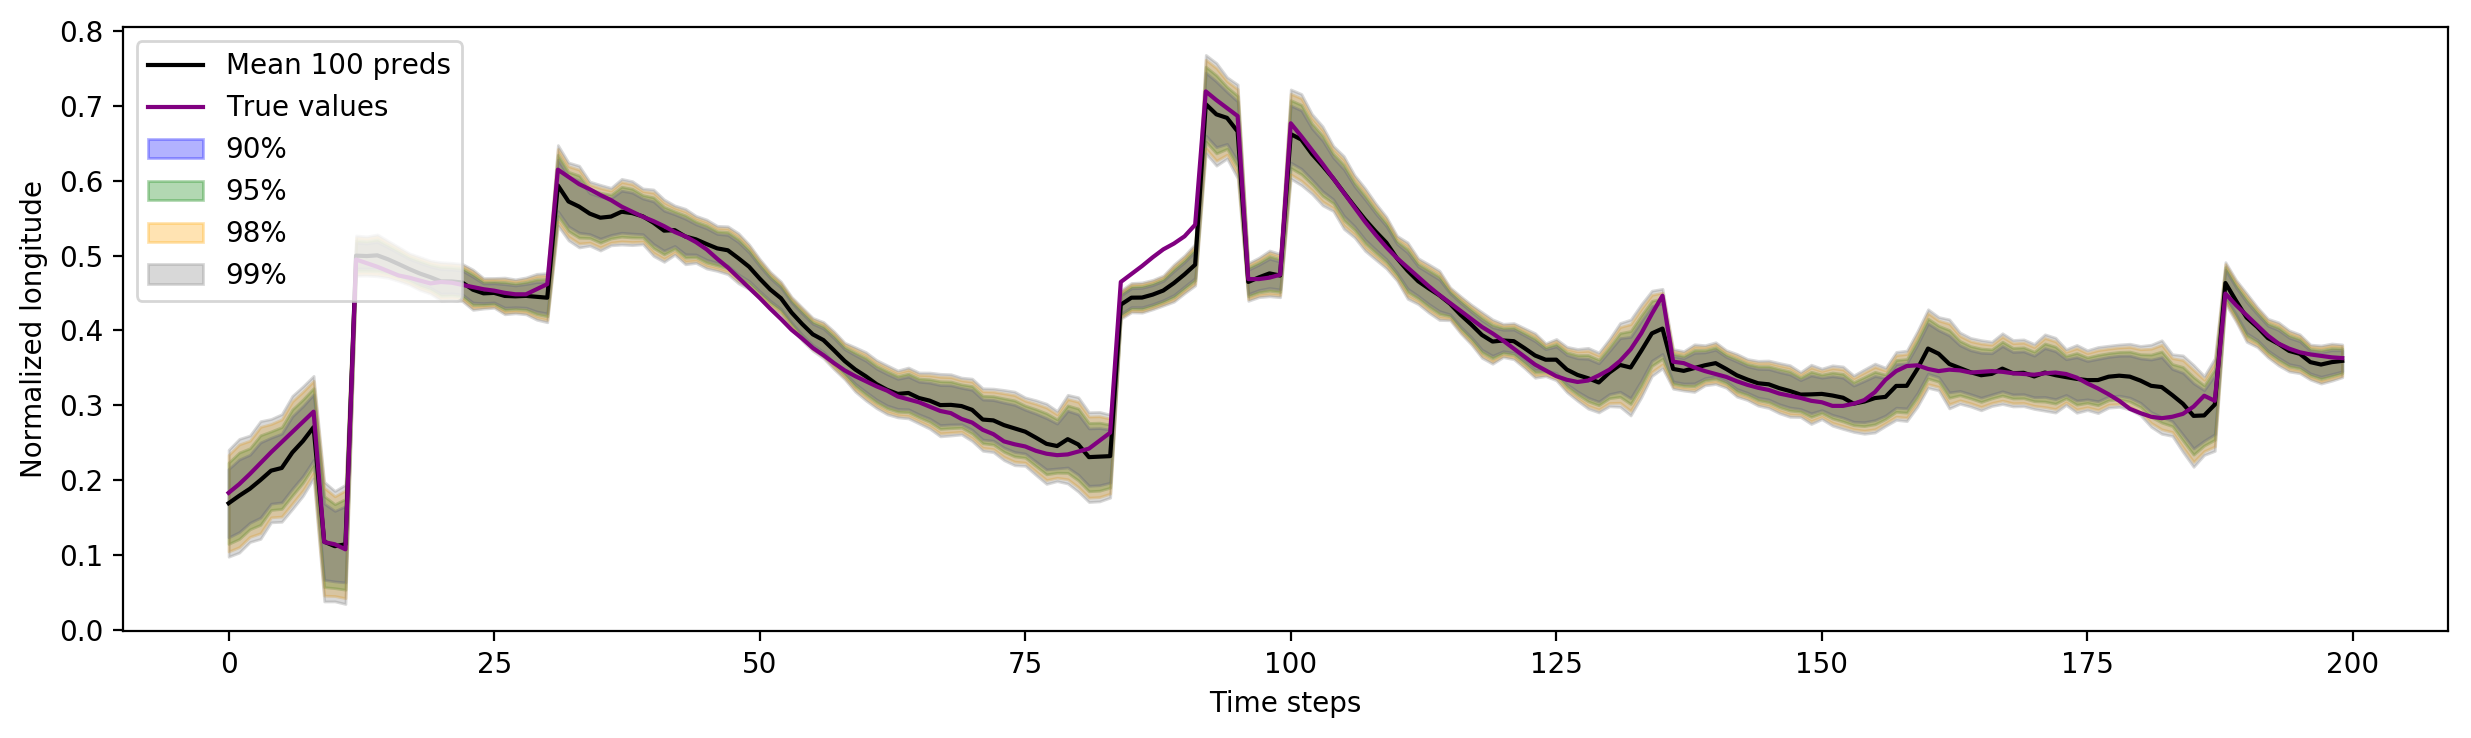

In [118]:
z_95 = 1.96
z_90 = 1.645
z_98 = 2.326
z_99 = 2.576

min1 = 0
max1 = 200
diff1 = max1 - min1

z_scores = [z_90, z_95, z_98, z_99]
colors = ['blue', 'yellow', 'orange', 'green']
pct = [90, 95, 98, 99]

plt.figure(figsize=(15, 4), dpi=100)
plt.plot(p100mean[:,1][min1:max1], color='black', label = 'Mean 100 preds')
plt.plot(y_test[:,1][min1:max1], color='purple', label = 'True values')
plt.fill_between(range(diff1), p100mean[:,1][min1:max1]-z_90*p100std[:,1][min1:max1], p100mean[:,1][min1:max1]+z_90*p100std[:,1][min1:max1], label='90%', color='blue', alpha=.3)
plt.fill_between(range(diff1), p100mean[:,1][min1:max1]-z_95*p100std[:,1][min1:max1], p100mean[:,1][min1:max1]+z_95*p100std[:,1][min1:max1], label='95%', color='green', alpha=.3)
plt.fill_between(range(diff1), p100mean[:,1][min1:max1]-z_98*p100std[:,1][min1:max1], p100mean[:,1][min1:max1]+z_98*p100std[:,1][min1:max1], label='98%', color='orange', alpha=.3)
plt.fill_between(range(diff1), p100mean[:,1][min1:max1]-z_99*p100std[:,1][min1:max1], p100mean[:,1][min1:max1]+z_99*p100std[:,1][min1:max1], label='99%', color='gray', alpha=.3)
plt.legend(loc='upper left')
plt.ylabel('Normalized longitude')
plt.xlabel('Time steps')
plt.show()

In [ ]:
z_95 = 1.96
z_90 = 1.645
z_98 = 2.326
z_99 = 2.576

z_scores = [z_90, z_95, z_98, z_99]
colors = ['blue', 'yellow', 'orange', 'green']
pct = [90, 95, 98, 99]

plt.figure(figsize=(15, 4), dpi=100)
plt.plot(p1100mean[:,1][2500:2600], color='black', label = 'Mean 100 preds')
plt.plot(y_test[:,1][2500:2600], color='purple', label = 'True values')
plt.fill_between(range(100), p100mean[:,1][2500:2600]-z_90*p1100std[:,0][2500:2600], p1100mean[:,1][2500:2600]+z_90*p1100std[:,0][2500:2600], label='90%', color='blue', alpha=.3)
plt.fill_between(range(100), p100mean[:,1][2500:2600]-z_95*p1100std[:,0][2500:2600], p1100mean[:,1][2500:2600]+z_95*p1100std[:,0][2500:2600], label='95%', color='green', alpha=.3)
plt.fill_between(range(100), p100mean[:,1][2500:2600]-z_98*p1100std[:,0][2500:2600], p1100mean[:,1][2500:2600]+z_98*p1100std[:,0][2500:2600], label='98%', color='orange', alpha=.3)
plt.fill_between(range(100), p100mean[:,1][2500:2600]-z_99*p1100std[:,0][2500:2600], p1100mean[:,1][2500:2600]+z_99*p1100std[:,0][2500:2600], label='99%', color='gray', alpha=.3)
plt.legend(loc='upper left')
plt.ylabel('Normalized longitude')
plt.xlabel('Time steps')
plt.show()

In [97]:
z_95 = 1.96
z_90 = 1.645
z_98 = 2.326
z_99 = 2.576

z_scores = [z_90, z_95, z_98, z_99]

for zs in z_scores:
    test_preds = p100mean[:,0]
    lower_bound = p100mean[:,0]-zs*p100std[:,0]
    upper_bound = p100mean[:,0]+zs*p100std[:,0]

    num_within_range = 0
    num_outside_range = 0
    for i in range(len(y_test)):
        if (lower_bound[i] <= y_test[i,0] <= upper_bound[i]):
            num_within_range = num_within_range + 1
        else:
            num_outside_range = num_outside_range + 1

    assert len(y_test) == num_within_range + num_outside_range
    pct_in_range = num_within_range / len(y_test)
    print(pct_in_range)

0.6384009691096305
0.7153240460327075
0.7831617201695942
0.8207147183525136


In [116]:
z_95 = 1.96
z_90 = 1.645
z_98 = 2.326
z_99 = 2.576

z_scores = [z_90, z_95, z_98, z_99]

for zs in z_scores:
    test_preds = p100mean[:,1]
    lower_bound = p100mean[:,1]-zs*p100std[:,1]
    upper_bound = p100mean[:,1]+zs*p100std[:,1]

    num_within_range = 0
    num_outside_range = 0
    for i in range(len(y_test)):
        if (lower_bound[i] <= y_test[i,1] <= upper_bound[i]):
            num_within_range = num_within_range + 1
        else:
            num_outside_range = num_outside_range + 1

    assert len(y_test) == num_within_range + num_outside_range
    pct_in_range = num_within_range / len(y_test)
    print(pct_in_range)

0.7607510599636584
0.8182919442761962
0.872198667474258
0.9012719563900666


In [96]:
len(y_test)

1651

In [101]:
p100mean[:,0].shape

(1651,)

In [132]:
#Katrina 
hurricane_groups = dfht.groupby('UNIQUE-KEY')
hdf = hurricane_groups.get_group('KATR-05')
min_to_start_predictions = 4
prediction_length = 4
max_hurricane = 89
yk = []
xk = []
ppxk = []
num_features = 6
y_cols = [7, 8]

for i in range(len(hdf)):
    if i < min_to_start_predictions - 1:
        print('beginning')

    elif i >= min_to_start_predictions - 1 and i < len(hdf) - prediction_length:
        print('middle')
        ppxk.append(hdf.iloc[0:i+1, :num_features])
        yk.append(hdf.iloc[i+prediction_length, y_cols])

    elif i >= len(hdf) - prediction_length:
        print('end')

yk = np.asarray(yk)
for i in range(len(ppxk)):
    xk.append(np.pad(ppxk[i], ((max_hurricane-len(ppxk[i]),0),(0,0)), 'constant'))
xk = np.asarray(xk)

beginning
beginning
beginning
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
middle
end
end
end
end


In [133]:
predsk = []
for i in range(100):
    model_output = model.predict(xk)
    predsk.append(model_output)

In [134]:
p100k = np.array(predsk)
p100meank = np.mean(p100k, axis=0)
p100stdk = np.std(p100k, axis=0)

In [135]:
yk

array([[0.4250559284116331, 0.2933204259438529],
       [0.4250559284116331, 0.2875121006776381],
       [0.41834451901565994, 0.28073572120038726],
       [0.4071588366890381, 0.2710551790900291],
       [0.40044742729306493, 0.26427879961277834],
       [0.3959731543624161, 0.25847047434656356],
       [0.38926174496644306, 0.2516940948693127],
       [0.3847874720357942, 0.24491771539206197],
       [0.3847874720357942, 0.23814133591481124],
       [0.38702460850111864, 0.23233301064859635],
       [0.3937360178970918, 0.22652468538238146],
       [0.40268456375838924, 0.21878025169409487],
       [0.4138702460850112, 0.2090997095837367],
       [0.4272930648769575, 0.20038722168441447],
       [0.44742729306487694, 0.19457889641819948],
       [0.4697986577181208, 0.1907066795740563],
       [0.4988814317673379, 0.1907066795740563],
       [0.534675615212528, 0.1907066795740563],
       [0.5682326621923938, 0.19554695062923533],
       [0.6017897091722596, 0.20038722168441447],
   

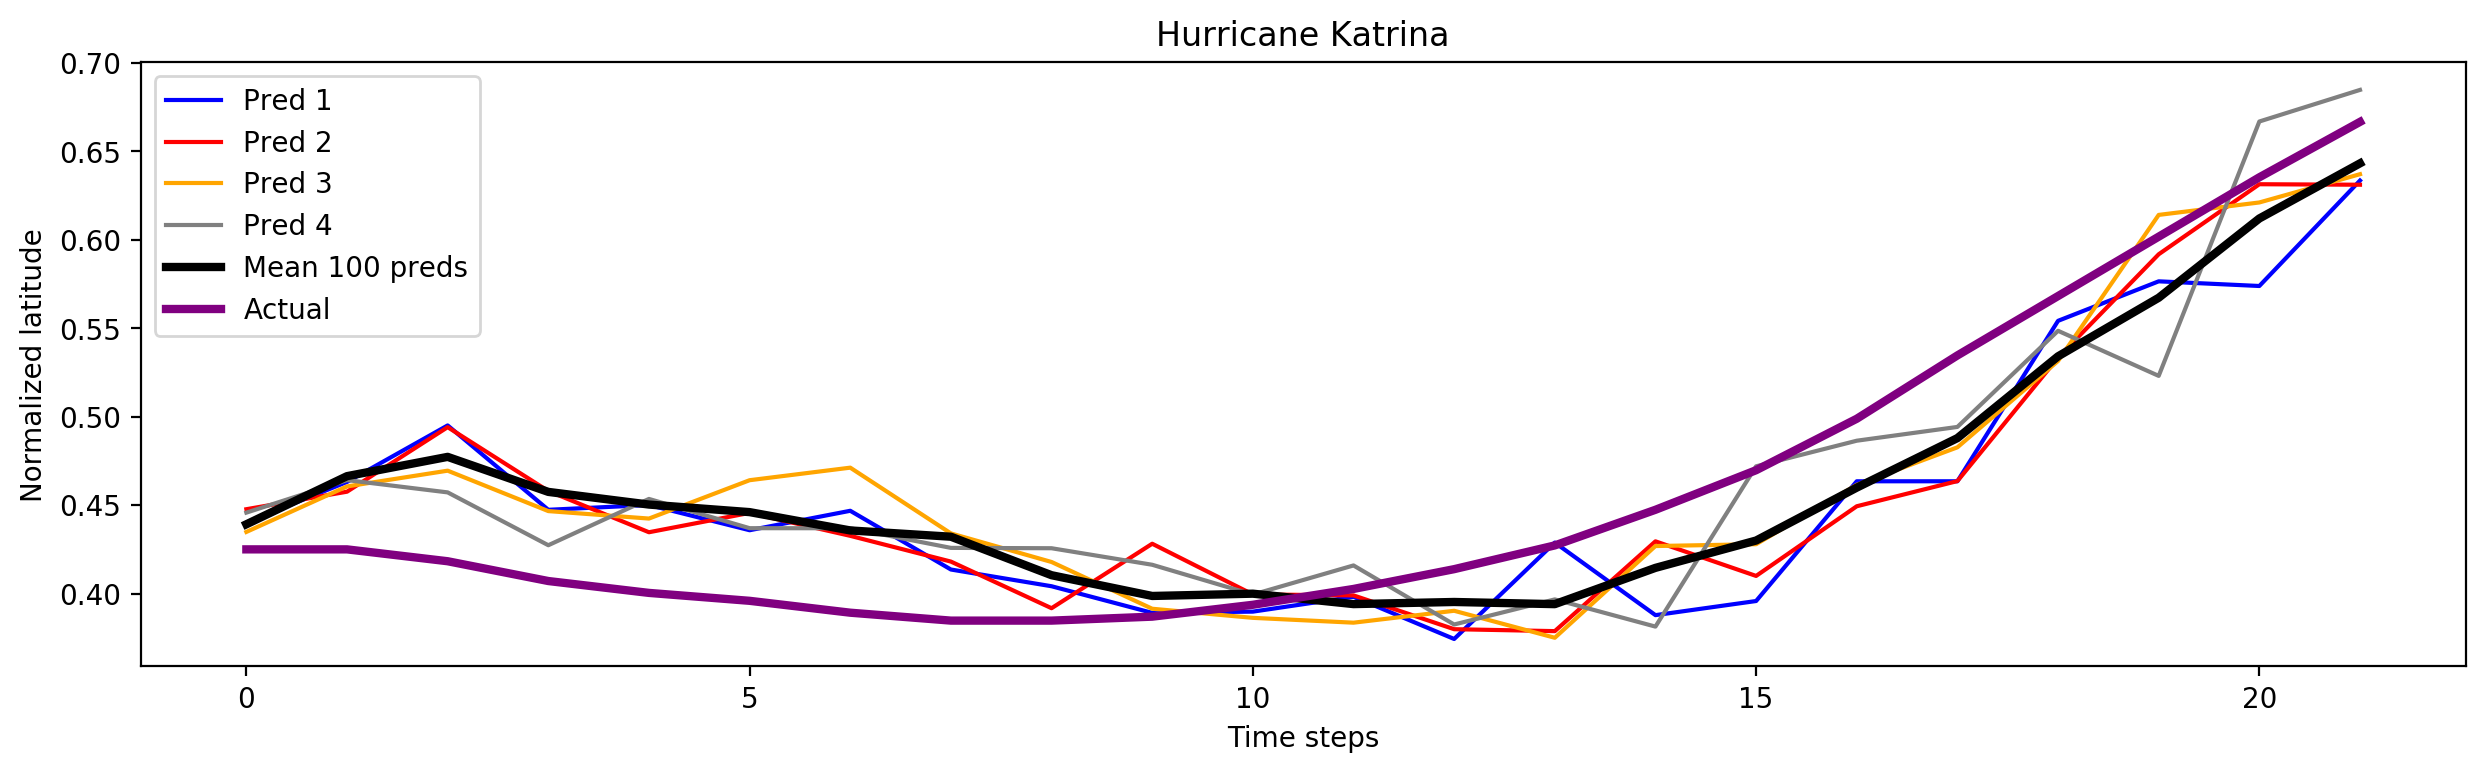

In [138]:
plt.figure(figsize=(15, 4), dpi=100)
plt.plot(p100k[3][:,0], color='blue', label='Pred 1')
plt.plot(p100k[13][:,0], color='red', label='Pred 2')
plt.plot(p100k[23][:,0], color='orange', label = 'Pred 3')
plt.plot(p100k[33][:,0], color='gray', label = 'Pred 4')
plt.plot(p100meank[:,0], color='black', linewidth=3, label = 'Mean 100 preds')
plt.plot(yk[:,0], color='purple', linewidth=3, label = 'Actual')
plt.legend(loc='upper left')
plt.title('Hurricane Katrina')
plt.ylabel('Normalized latitude')
plt.xlabel('Time steps')
plt.show()

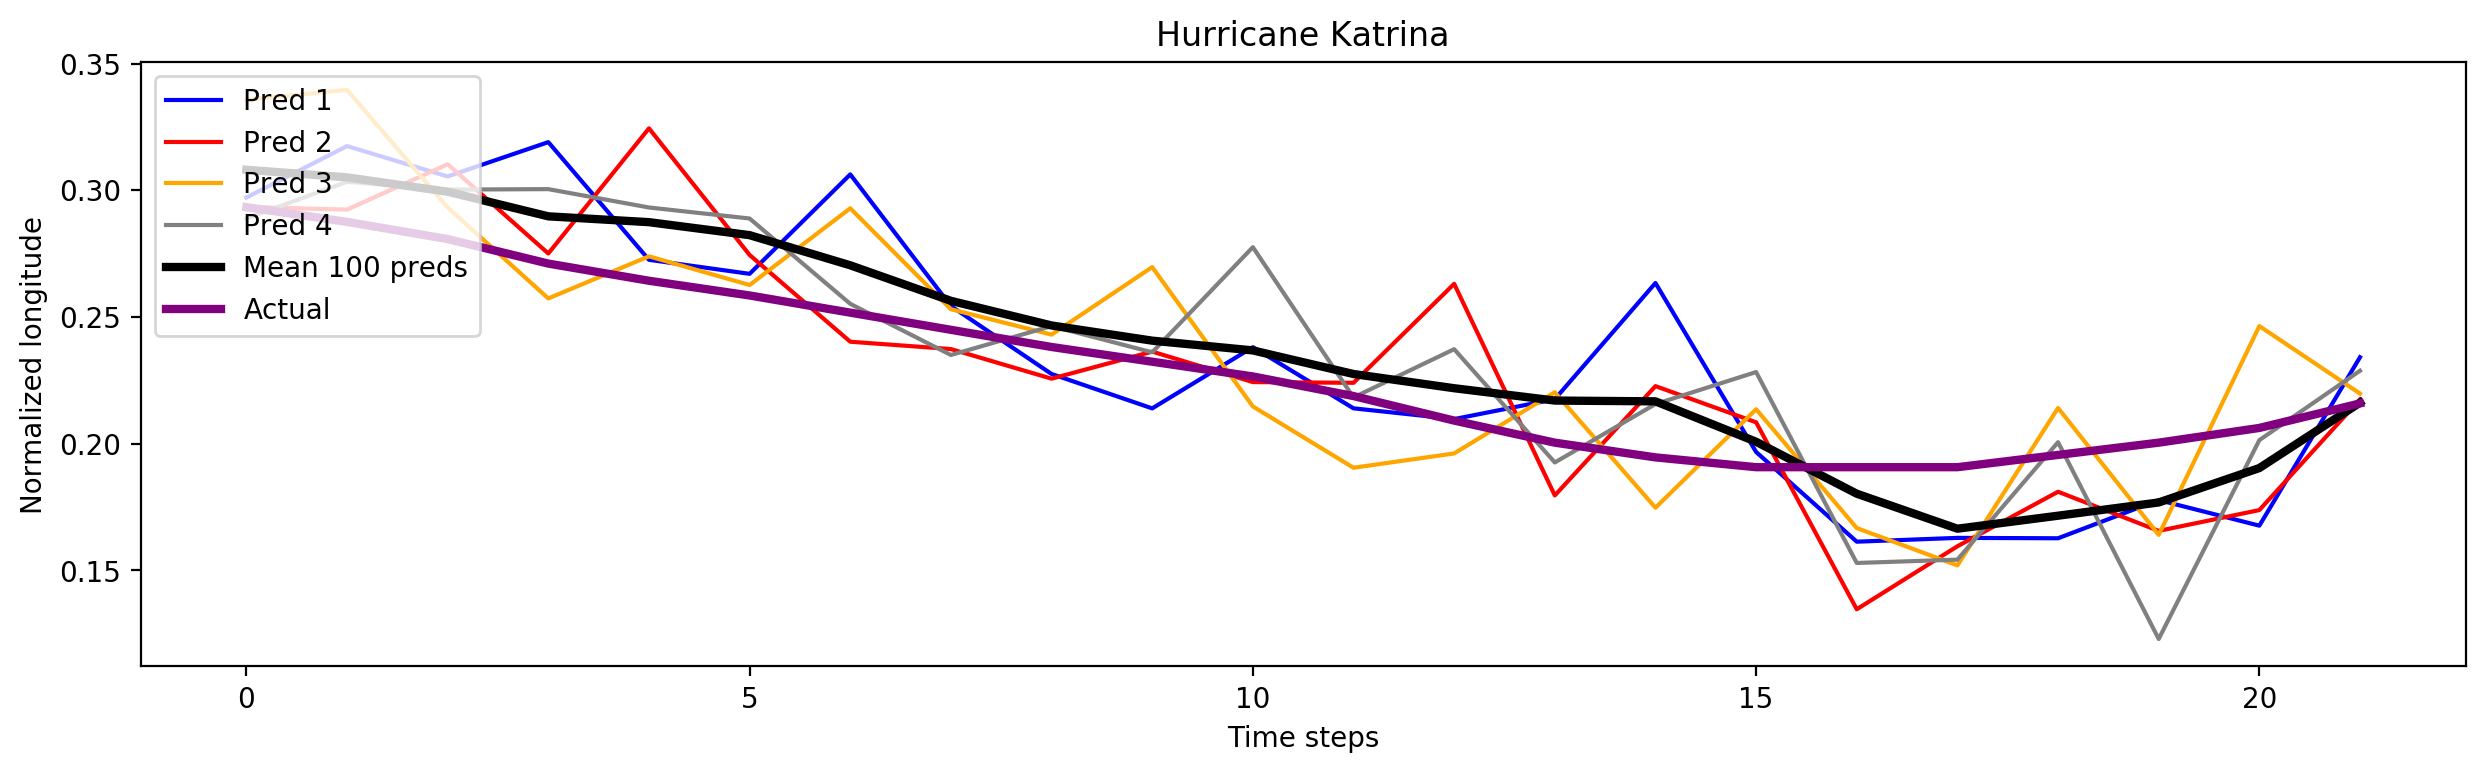

In [139]:
plt.figure(figsize=(15, 4), dpi=100)
plt.plot(p100k[3][:,1], color='blue', label='Pred 1')
plt.plot(p100k[13][:,1], color='red', label='Pred 2')
plt.plot(p100k[23][:,1], color='orange', label = 'Pred 3')
plt.plot(p100k[33][:,1], color='gray', label = 'Pred 4')
plt.plot(p100meank[:,1], color='black', linewidth=3, label = 'Mean 100 preds')
plt.plot(yk[:,1], color='purple', linewidth=3, label = 'Actual')
plt.legend(loc='upper left')
plt.title('Hurricane Katrina')
plt.ylabel('Normalized longitude')
plt.xlabel('Time steps')
plt.show()

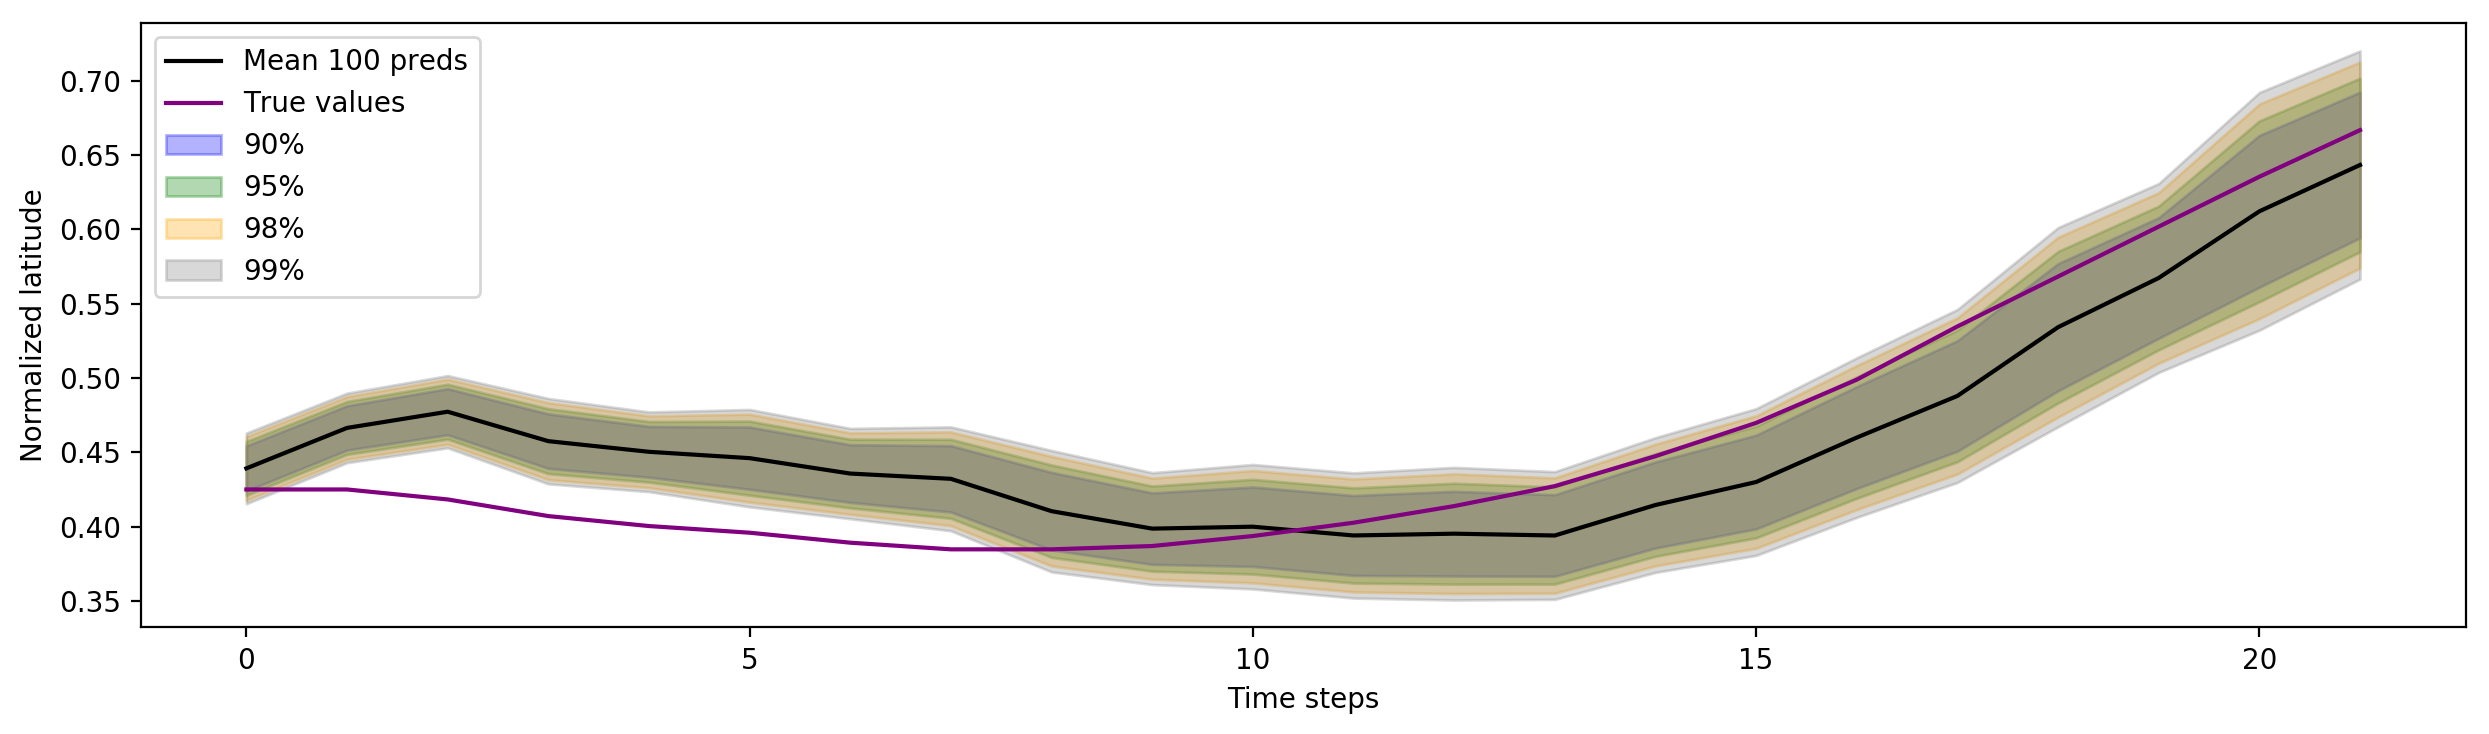

In [142]:
z_95 = 1.96
z_90 = 1.645
z_98 = 2.326
z_99 = 2.576

z_scores = [z_90, z_95, z_98, z_99]
colors = ['blue', 'yellow', 'orange', 'green']
pct = [90, 95, 98, 99]

plt.figure(figsize=(15, 4), dpi=100)
plt.plot(p100meank[:,0], color='black', label = 'Mean 100 preds')
plt.plot(yk[:,0], color='purple', label = 'True values')
plt.fill_between(range(len(yk)), p100meank[:,0]-z_90*p100stdk[:,0], p100meank[:,0]+z_90*p100stdk[:,0], label='90%', color='blue', alpha=.3)
plt.fill_between(range(len(yk)), p100meank[:,0]-z_95*p100stdk[:,0], p100meank[:,0]+z_95*p100stdk[:,0], label='95%', color='green', alpha=.3)
plt.fill_between(range(len(yk)), p100meank[:,0]-z_98*p100stdk[:,0], p100meank[:,0]+z_98*p100stdk[:,0], label='98%', color='orange', alpha=.3)
plt.fill_between(range(len(yk)), p100meank[:,0]-z_99*p100stdk[:,0], p100meank[:,0]+z_99*p100stdk[:,0], label='99%', color='gray', alpha=.3)
plt.legend(loc='upper left')
plt.ylabel('Normalized latitude')
plt.xlabel('Time steps')
plt.show()

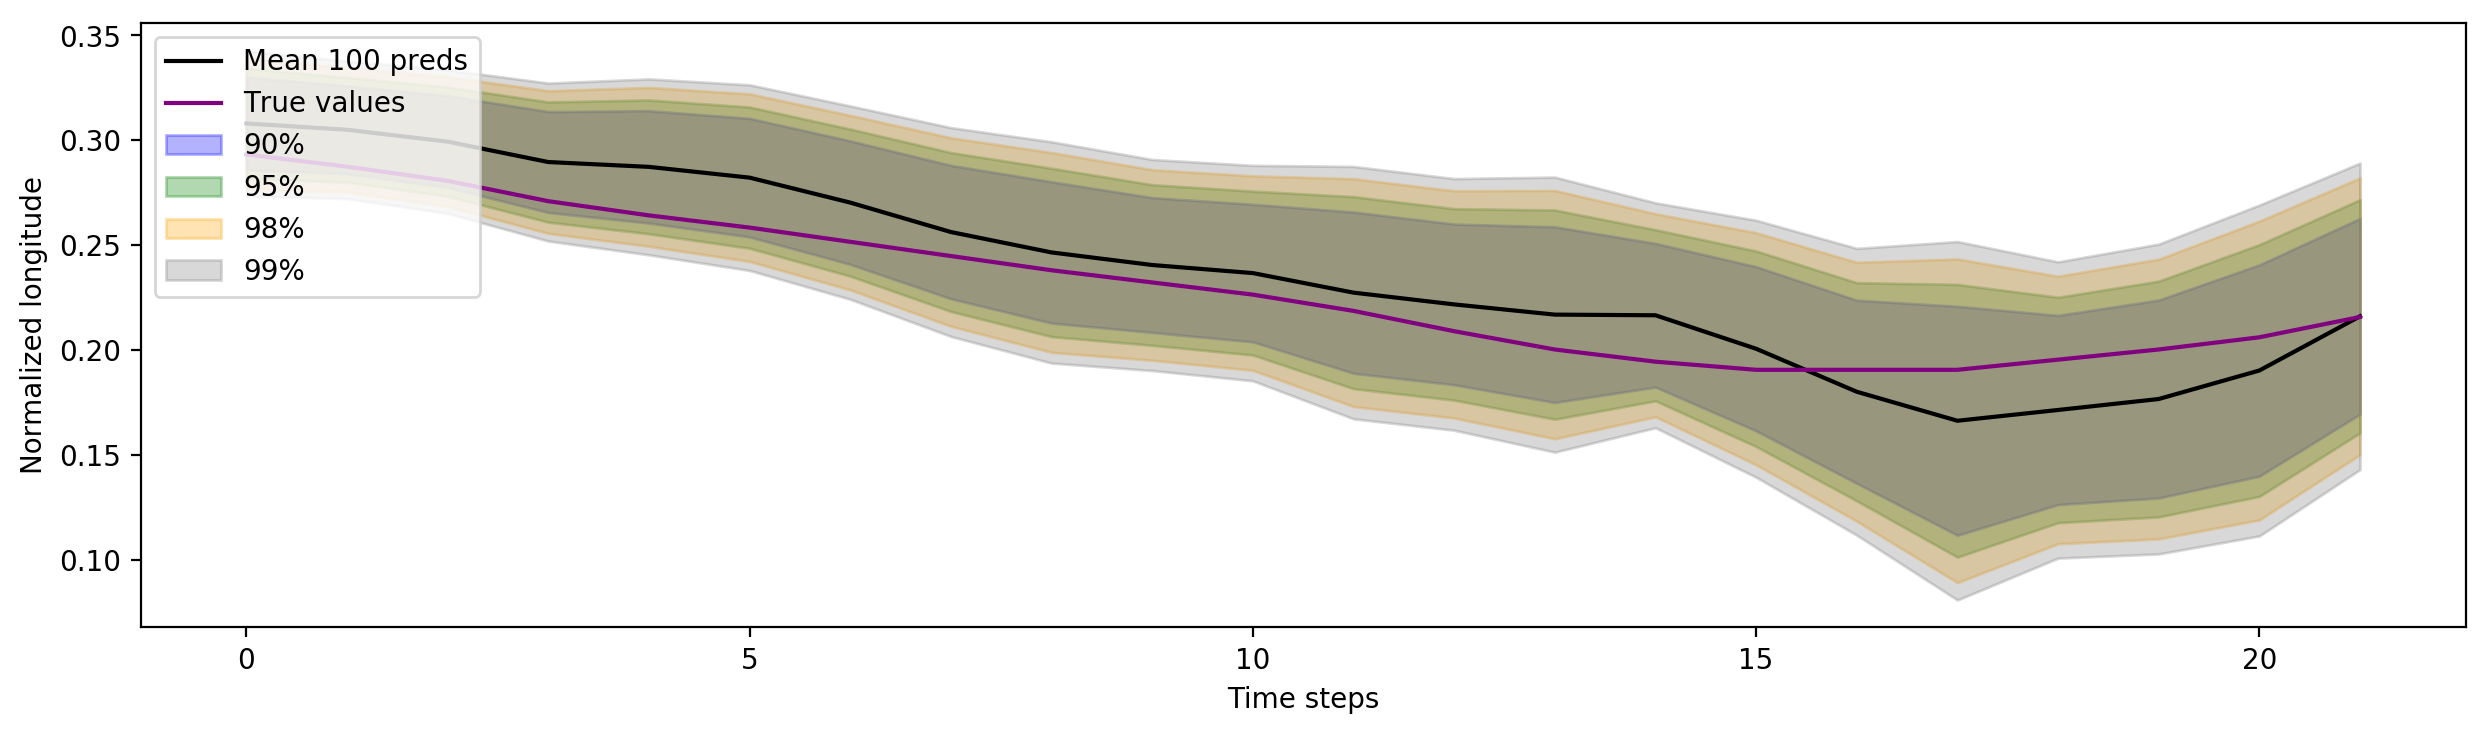

In [143]:
z_95 = 1.96
z_90 = 1.645
z_98 = 2.326
z_99 = 2.576

z_scores = [z_90, z_95, z_98, z_99]
colors = ['blue', 'yellow', 'orange', 'green']
pct = [90, 95, 98, 99]

plt.figure(figsize=(15, 4), dpi=100)
plt.plot(p100meank[:,1], color='black', label = 'Mean 100 preds')
plt.plot(yk[:,1], color='purple', label = 'True values')
plt.fill_between(range(len(yk)), p100meank[:,1]-z_90*p100stdk[:,1], p100meank[:,1]+z_90*p100stdk[:,1], label='90%', color='blue', alpha=.3)
plt.fill_between(range(len(yk)), p100meank[:,1]-z_95*p100stdk[:,1], p100meank[:,1]+z_95*p100stdk[:,1], label='95%', color='green', alpha=.3)
plt.fill_between(range(len(yk)), p100meank[:,1]-z_98*p100stdk[:,1], p100meank[:,1]+z_98*p100stdk[:,1], label='98%', color='orange', alpha=.3)
plt.fill_between(range(len(yk)), p100meank[:,1]-z_99*p100stdk[:,1], p100meank[:,1]+z_99*p100stdk[:,1], label='99%', color='gray', alpha=.3)
plt.legend(loc='upper left')
plt.ylabel('Normalized longitude')
plt.xlabel('Time steps')
plt.show()

In [145]:
z_95 = 1.96
z_90 = 1.645
z_98 = 2.326
z_99 = 2.576

z_scores = [z_90, z_95, z_98, z_99]

for zs in z_scores:
    test_preds = p100meank[:,0]
    lower_bound = p100meank[:,0]-zs*p100stdk[:,0]
    upper_bound = p100meank[:,0]+zs*p100stdk[:,0]

    num_within_range = 0
    num_outside_range = 0
    for i in range(len(yk)):
        if (lower_bound[i] <= yk[i,0] <= upper_bound[i]):
            num_within_range = num_within_range + 1
        else:
            num_outside_range = num_outside_range + 1

    assert len(yk) == num_within_range + num_outside_range
    pct_in_range = num_within_range / len(yk)
    print(pct_in_range)

0.45454545454545453
0.5454545454545454
0.6818181818181818
0.6818181818181818


In [146]:
z_95 = 1.96
z_90 = 1.645
z_98 = 2.326
z_99 = 2.576

z_scores = [z_90, z_95, z_98, z_99]

for zs in z_scores:
    test_preds = p100meank[:,1]
    lower_bound = p100meank[:,1]-zs*p100stdk[:,1]
    upper_bound = p100meank[:,1]+zs*p100stdk[:,1]

    num_within_range = 0
    num_outside_range = 0
    for i in range(len(yk)):
        if (lower_bound[i] <= yk[i,1] <= upper_bound[i]):
            num_within_range = num_within_range + 1
        else:
            num_outside_range = num_outside_range + 1

    assert len(yk) == num_within_range + num_outside_range
    pct_in_range = num_within_range / len(yk)
    print(pct_in_range)

1.0
1.0
1.0
1.0
